In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm import tqdm
import torch
import numpy as np
import pytorch_lightning as pl
from collections import defaultdict
import scipy

from gw150814_simulator import GW150814, defaults, GW150814_Additive
import os, sys
sys.path.append("../")
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule
from utils.gof import t_to_pvalue_empirical, t_to_pvalue

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('mystyle.mplstyle')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Simulator

In [3]:
gw150814_post = torch.load('./stores/gw150814_white_post_d8_m1_1010k.pt')
gw150814_noise = torch.load('./stores/gw150814_white_noise_d8_m1_10M.pt')
gw150814_samples = {'mu': gw150814_post, 'noise': gw150814_noise}
simulator = GW150814_Additive(
    gw150814_samples=gw150814_samples, 
    bounds=2, 
    dtype=torch.float32,
    fraction = 0.5
)

times = simulator._process(simulator.times)
Nbins = simulator.Nbins

Loading data for H1 at GPS time 1126259462.4
Loading PSD for H1 at GPS time 1126259462.4 [can take O(1 min)]
Loading posterior samples from GW150814_posterior_samples.npz


#### Checks

100%|██████████| 500/500 [00:00<00:00, 770.73it/s]


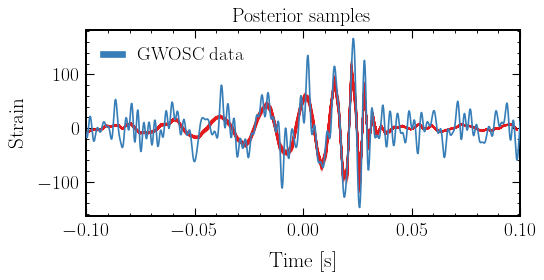

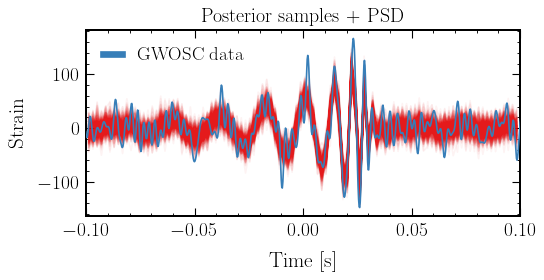

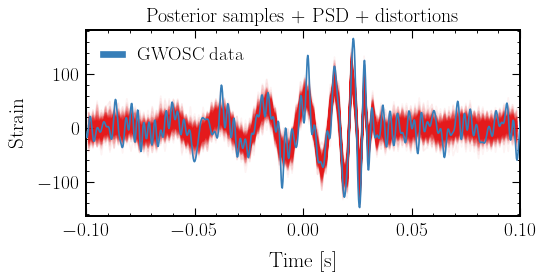

In [4]:
samples = simulator.sample(1000)

# mu samples
plt.figure(figsize=(7, 3))
plt.title("Posterior samples")
for i in tqdm(range(500)):
    plt.plot(times, samples['mu'][i], color="C0", alpha=0.05)
plt.plot(simulator.times, simulator.filter_gwosc_data(), color="C1", zorder=10, label="GWOSC data")
plt.xlim(-0.1, 0.1)
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.legend();

# x0 samples
plt.figure(figsize=(7, 3))
plt.title("Posterior samples + PSD")
for i in tqdm(range(500)):
    plt.plot(times, samples['x0'][i], color="C0", alpha=0.05)
plt.plot(simulator.times, simulator.filter_gwosc_data(), color="C1", zorder=10, label="GWOSC data")
plt.xlim(-0.1, 0.1)
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.legend();

# xi samples
plt.figure(figsize=(7, 3))
plt.title("Posterior samples + PSD + distortions")
for i in tqdm(range(500)):
    plt.plot(times, samples['xi'][i], color="C0", alpha=0.05)
plt.plot(simulator.times, simulator.filter_gwosc_data(), color="C1", zorder=10, label="GWOSC data")
plt.xlim(-0.1, 0.1)
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.legend();

## Training SNR

In [5]:
from models.online_norm import OnlineStandardizingLayer
from models.resnet_1d import ResidualNet


class Network_SNR(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.online_norm = OnlineStandardizingLayer((Nbins,), use_average_std=True) 
        self.net = ResidualNet(1, 1, 128)
        self.logvariance = torch.nn.Parameter(torch.ones(Nbins)*8)
                
    def epsilon(self, x):
        x = self.online_norm(x)
        x = self.net(x.unsqueeze(1)).squeeze(1)
        return x
    
    def snr(self, x):
        return self.epsilon(x) / self.logvariance.exp().sqrt()  # [B, N_bins]
    
    def bounds(self):
        return self.logvariance.detach().exp().sqrt().mean(-1) * 5
        
    def forward(self, x):
        
        # Adaptive data generation
        ni = x['ni']
        epsilon_sim =  (2 * self.bounds() * torch.rand(x['x'].shape, device= x['x'].device, dtype= x['x'].dtype) - self.bounds()) * ni
        data =  x['x0'] + epsilon_sim * ni

        epsilon = self.epsilon(data)
        mask = ( x['ni'] != 0 )  
        squared_error = (epsilon - epsilon_sim)**2                                                                    # [B, N_bins]
        l = squared_error / (self.logvariance.exp() + 1e-10) + self.logvariance                     # [B, N_bins]
        return (l * mask.float()).sum() * 0.5

In [6]:
# Train
def resample(sample):
    sample = simulator._resample(sample)
    sample['x'] = sample['xi']
    sample = {k: v for k, v in sample.items()}
    return sample

batch_size = 128
# dm = StoredDataModule(samples, batch_size=batch_size, on_after_load_sample=resample)
dm = OnTheFlyDataModule(simulator, Nsims_per_epoch=400*batch_size, batch_size=batch_size)
network_SNR = Network_SNR()
model = CustomLossModule_withBounds(network_SNR, learning_rate=8e-3)
trainer = pl.Trainer(
    accelerator="gpu", 
    max_epochs=100, 
    precision=32,
    # fast_dev_run=True
)
trainer.fit(model, dm)
network_SNR.cuda().eval();

/home/noemiam/.pyenv/versions/swyft-3.10.0/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/noemiam/.pyenv/versions/swyft-3.10.0/lib/pytho ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/noemiam/.pyenv/versions/swyft-3.10.0/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorbo

Sanity Checking: 0it [00:00, ?it/s]

/home/noemiam/.pyenv/versions/swyft-3.10.0/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/noemiam/.pyenv/versions/swyft-3.10.0/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 23599.127


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2968.596 >= min_delta = 0.0. New best score: 20630.531


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 483.736 >= min_delta = 0.0. New best score: 20146.795


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 29.316 >= min_delta = 0.0. New best score: 20117.479


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.137 >= min_delta = 0.0. New best score: 20113.342


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.623 >= min_delta = 0.0. New best score: 20106.719


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00013: reducing learning rate of group 0 to 4.0000e-03.
Epoch 00013: reducing learning rate of group 1 to 4.0000e-03.


Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 20106.719. Signaling Trainer to stop.


Reloading best model: /home/noemiam/sbi/gofish/GW/lightning_logs/version_43/checkpoints/epoch=6-val_loss=20106.72.ckpt


tensor(62.4175, device='cuda:0')

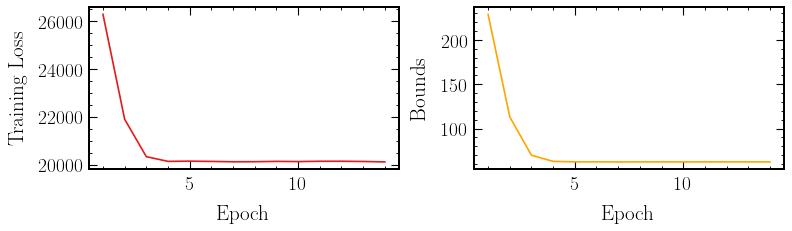

In [7]:
# Convert tensors to scalars if they are tensors
train_loss_history = [loss.item() if hasattr(loss, 'item') else loss for loss in model.train_loss_history]
bounds_history = [bound.item() if hasattr(bound, 'item') else bound for bound in model.bounds_history]

# Generate a list of epoch numbers
epochs = range(1, len(train_loss_history) + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
# Plot Training Loss over Epochs
axs[0].plot(epochs, train_loss_history)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Training Loss')
# Plot Bounds over Epochs
axs[1].plot(epochs, bounds_history, label='Bounds', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Bounds')
plt.tight_layout();

network_SNR.bounds()

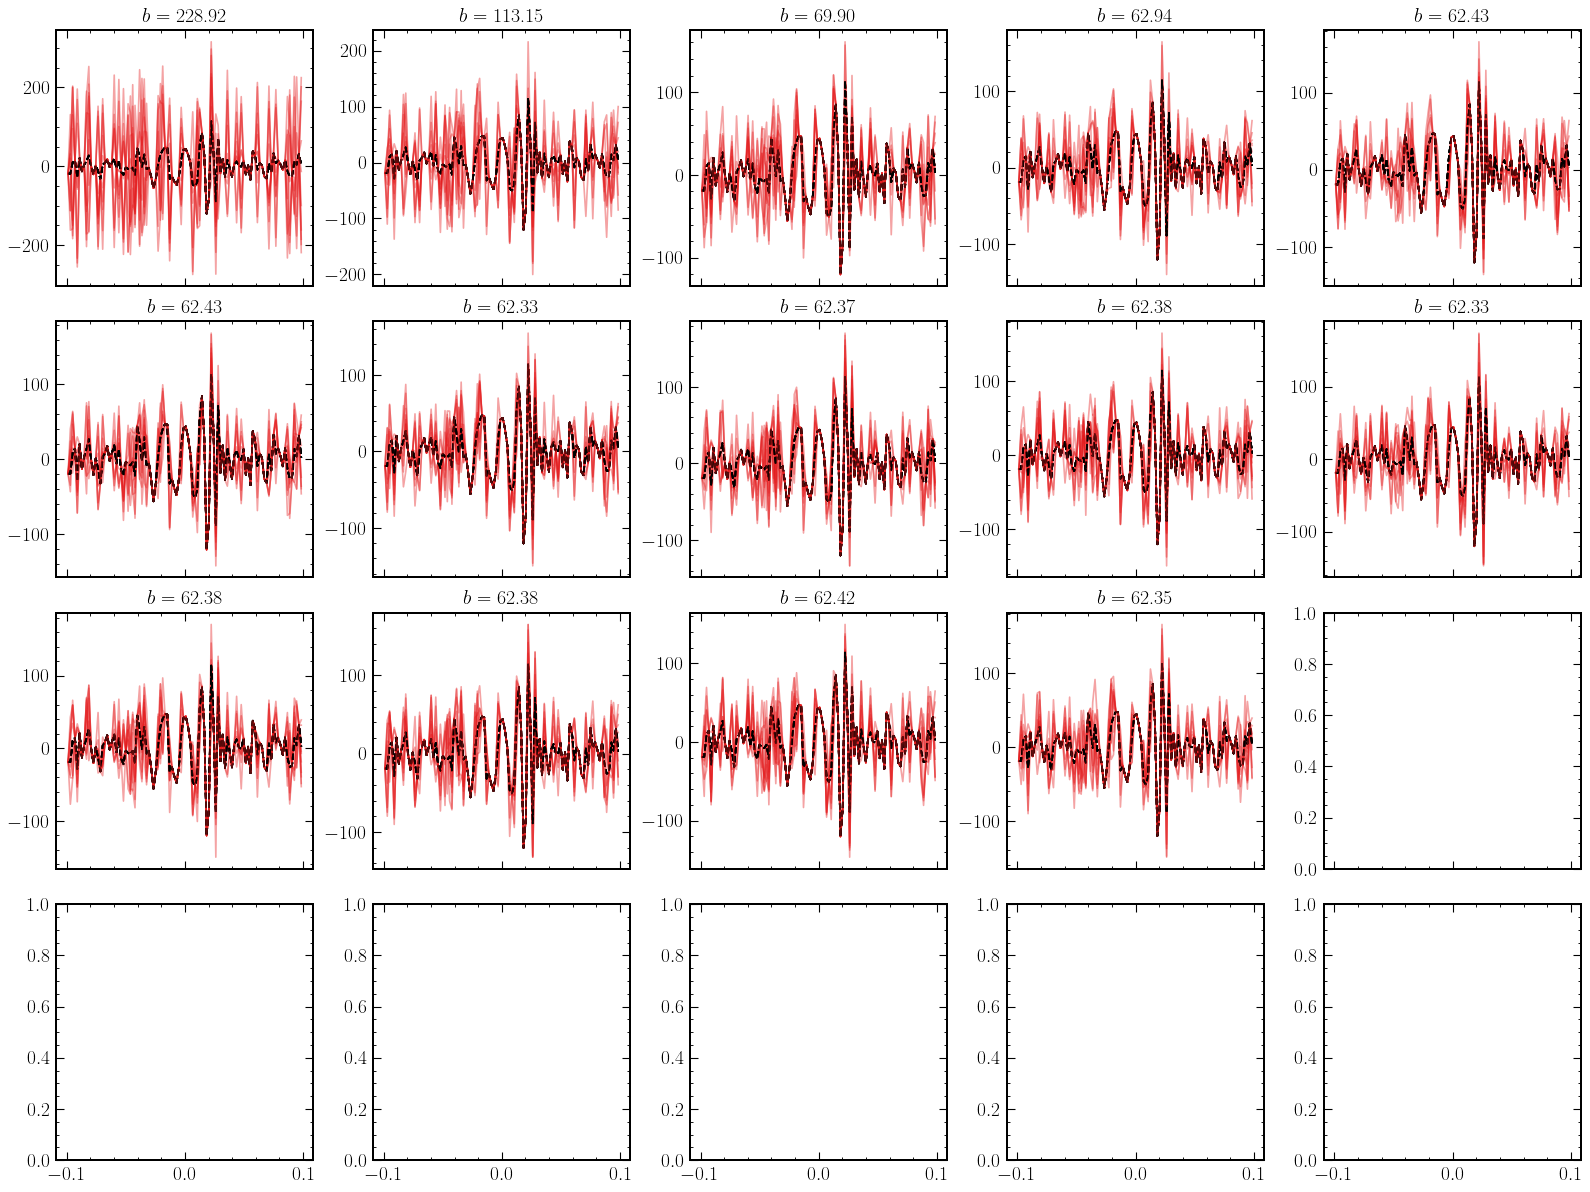

In [8]:
# Distotions enveloping the data
bounds_history = [bound.item() if hasattr(bound, 'item') else bound for bound in model.bounds_history]
sample = simulator.sample(1)
ni = sample['ni']

fig, axs = plt.subplots(4, 5, figsize=(20, (4+1)*3), sharex=True)
axs = axs.flatten()
for i_b, b in enumerate(bounds_history):
    if i_b < len(axs):
        axs[i_b].set_title(r"$b$ = {:.2f}".format(b))
        for j in range(10):
            # sample = simulator.sample(1)
            ni = sample['ni']
            axs[i_b].plot(times, sample['x0'][0].cpu(), c='k', ls='--')
            epsilon_sim =  (2 * b * torch.rand(sample['xi'].shape, device= sample['xi'].device, dtype= sample['xi'].dtype) - b) * ni
            data =  sample['x0'] + epsilon_sim * ni
            axs[i_b].plot(times, data[0].cpu(), c='C0', alpha=0.4)
plt.tight_layout();

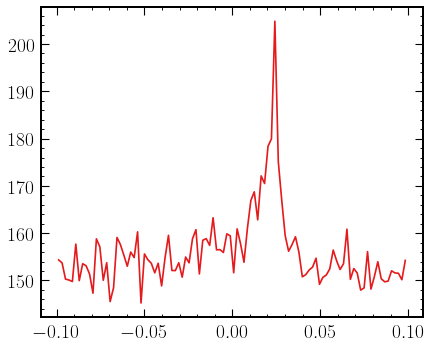

In [9]:
plt.plot(times, network_SNR.logvariance.exp().detach().cpu());

---

## Evaluate SNR

#### From here on test with bounds to which the NN converged to: 

In [10]:
bounds = network_SNR.bounds().detach().cpu().numpy().item()
simulator = GW150814_Additive(gw150814_samples=gw150814_samples, bounds=bounds, dtype=torch.float32, fraction=0.1)

Loading data for H1 at GPS time 1126259462.4
Loading PSD for H1 at GPS time 1126259462.4 [can take O(1 min)]
Loading posterior samples from GW150814_posterior_samples.npz


#### Monte-Carlo H0

$$
    t_i(\mathbf x) \propto \text{SNR}_i^2(\bm x)  
$$

In [11]:
N_mc = 1e6

# if os.path.exists("mc_h0.npy"):
#     ts_bin_H0_SNR = np.load("mc_h0.npy")
# else:
batch_size = 2048*2
N_batch = int(N_mc / batch_size)
ts_bin_H0_SNR = []
for _ in tqdm(range(N_batch)):
    mc_samples = simulator.sample(batch_size)
    ts_batch =  (network_SNR.snr(mc_samples['x0'].cuda())**2).detach().cpu().numpy()
    ts_bin_H0_SNR.append(ts_batch)
    
ts_bin_H0_SNR = np.concatenate(ts_bin_H0_SNR)
ts_bin_H0_SNR.shape

  2%|▏         | 6/244 [00:01<01:03,  3.75it/s]

100%|██████████| 244/244 [01:08<00:00,  3.57it/s]


(999424, 102)

Histogram of $t_i | H_0$ in individual bins

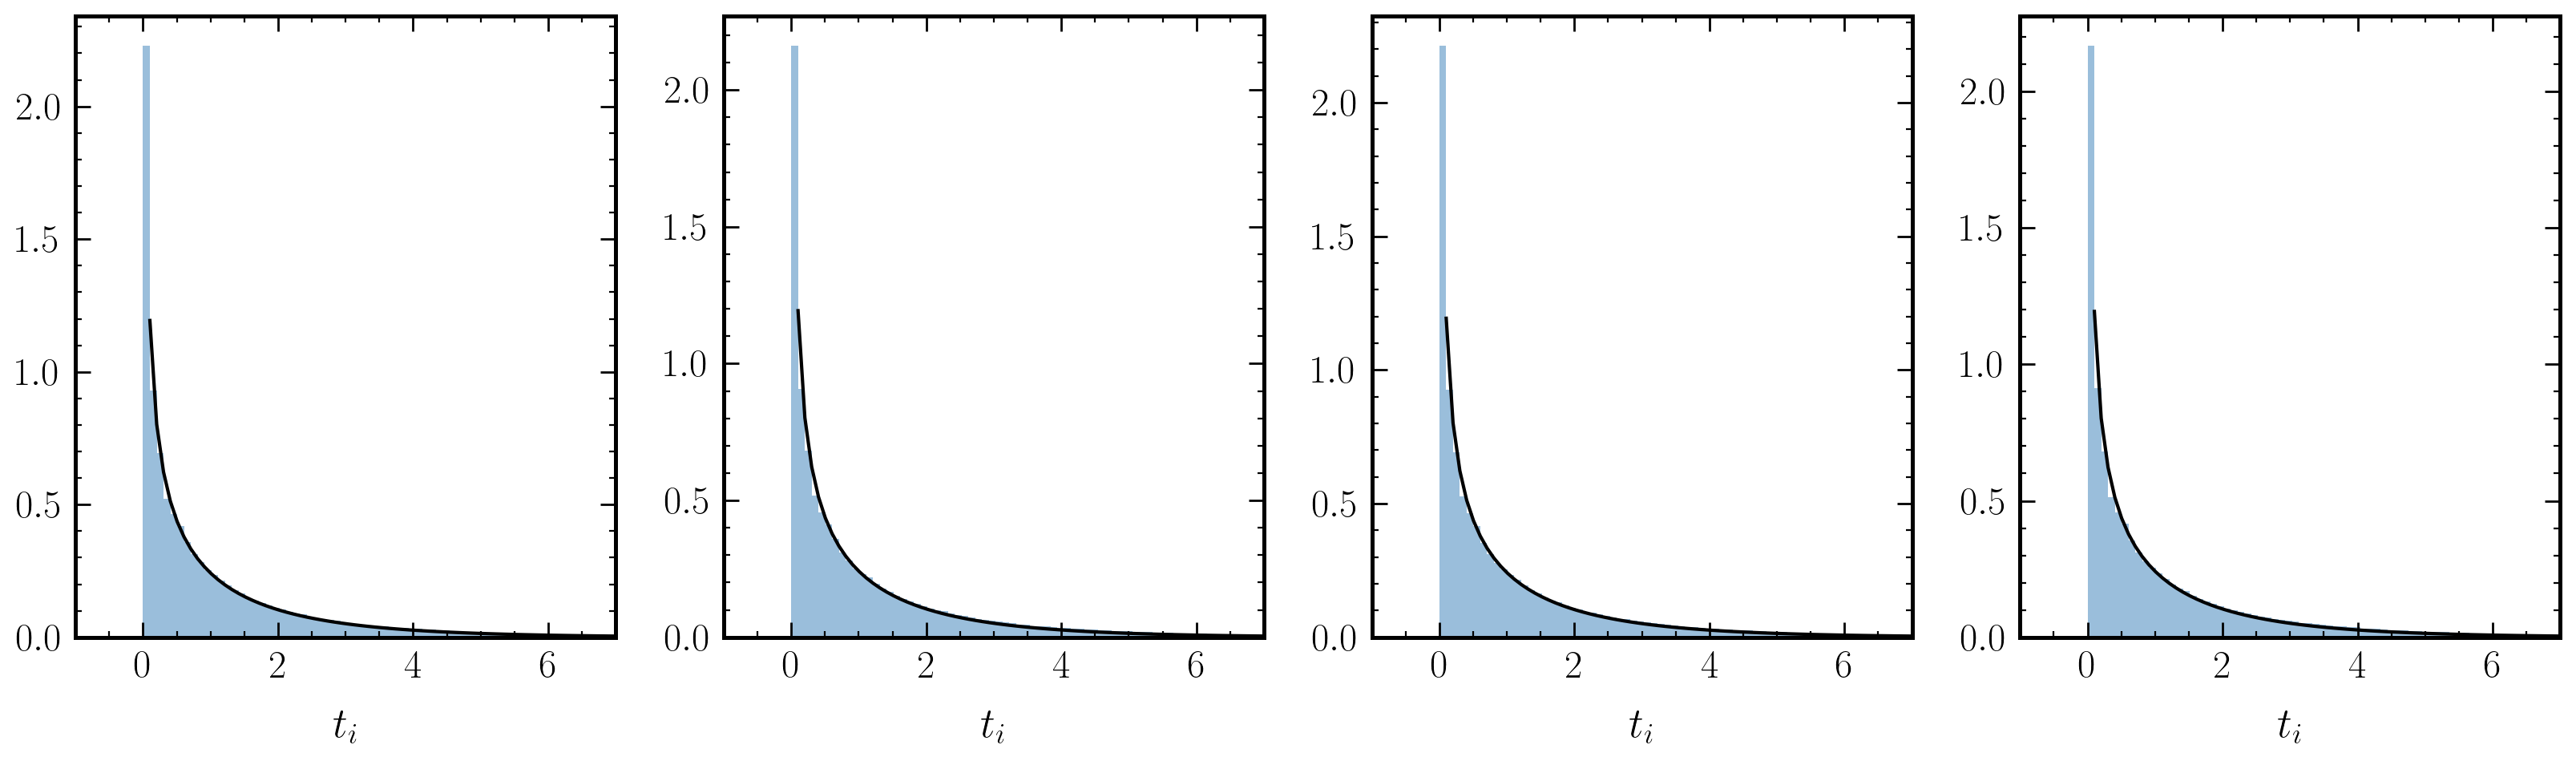

In [12]:
# Compare with chi2 with df = 1
grid = np.linspace(0, 10, 100) # 1 df, adjust
chi2 = scipy.stats.chi2.pdf(grid, df=1, loc=0)

fig, axs = plt.subplots(1, 4, figsize=(20, 5), dpi=200)
for i in range(4):
    bin = torch.randint(Nbins, (1,))
    ts_bin_i = ts_bin_H0_SNR[:, bin]

    bins = np.linspace(0, 10, 100)
    axs[i].hist(ts_bin_i, bins=bins, density=True, color='C1', alpha=0.5)    
    axs[i].set_xlabel('$t_i$')
    axs[i].set_xlim(-1, 7)
    axs[i].plot(grid, chi2, c='k', label='$\chi^2$ with df=1')

---

### Individual deviations test

- Localized $t_i$
- Localized $\mathrm{p}_i$ for anomaly detection
- Residual analysis with $\epsilon_i$ map

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


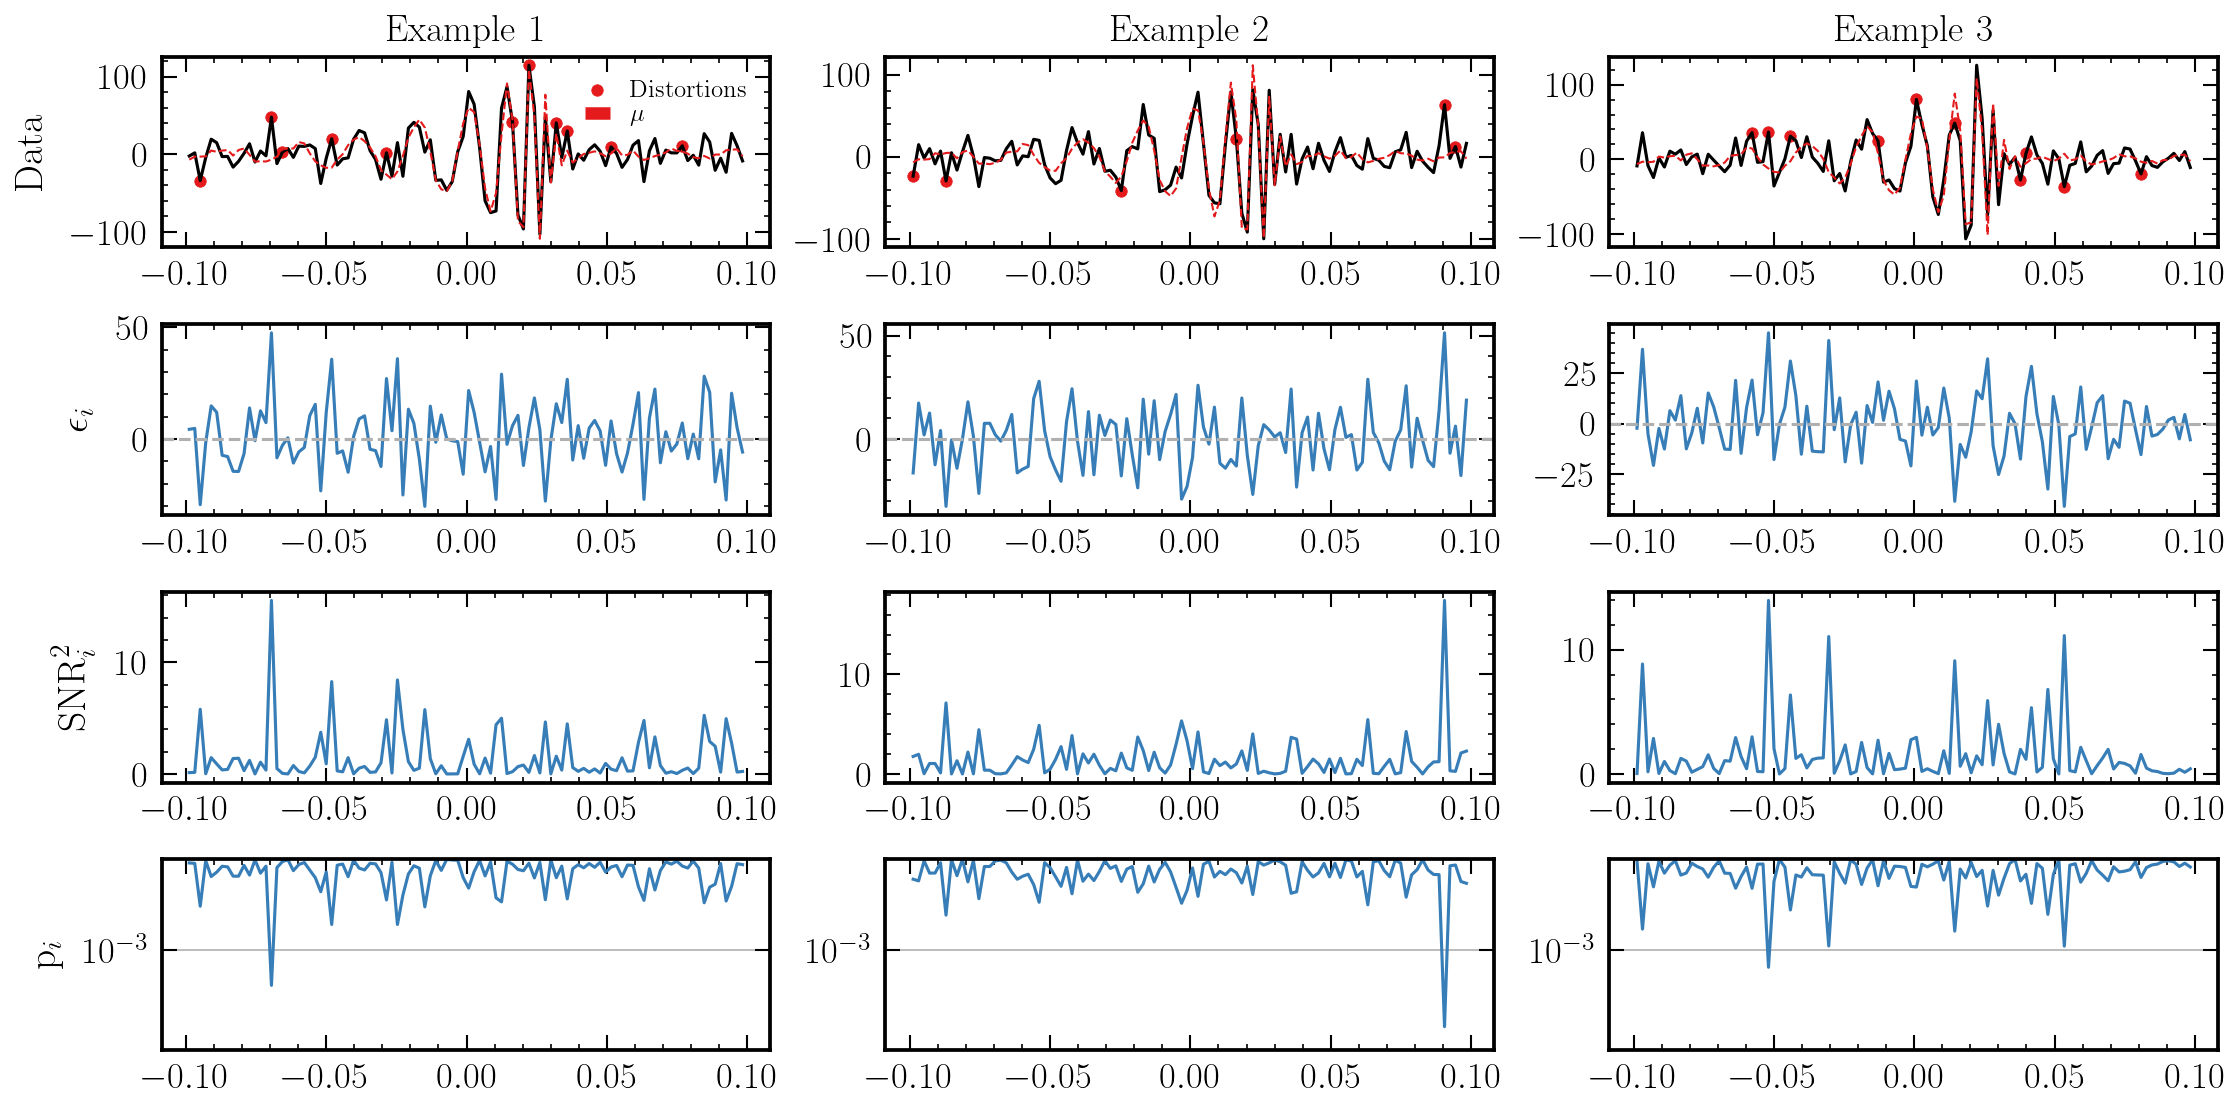

In [13]:
fig, axs = plt.subplots(4, 3, figsize=(15, 7.5), dpi=150)
for i in range(3):
    
    # Get sample
    obs = simulator.sample(1) 
    
    # Evaluate epsilon and SNR^2 test statistic from NN
    epsilon_nn = network_SNR.epsilon(obs['xi'].cuda()).detach().cpu().numpy().squeeze(0)
    snr2_nn = network_SNR.snr(obs['xi'].cuda()).detach().cpu().numpy().squeeze(0)**2

    # Compute p-values
    _p_nn = []
    for idx, ts_bin in enumerate(snr2_nn):
        ts_bin_i = ts_bin_H0_SNR[:, idx]
        m = ts_bin_i.mean()
        ts0_ref = ts_bin_i - m
        ts_obs = (ts_bin-m)
        _p_nn.append(t_to_pvalue_empirical(ts_obs, ts0_ref))  
    p_nn = np.array(_p_nn) 
    
    # Plotting
    x = obs['xi'][0]
    ni = obs['ni'][0] 
    epsilon = obs['epsilon'][0] 
    grid = times
    
    axs[0, i].plot(grid, obs['xi'][0], c='k')
    axs[0, i].scatter(grid[ni!=0], y=x[ni!=0], c='C0', s=30, marker='o',linewidths=0.4)
    axs[0, i].plot(grid, obs['mu'][0], c='C0', ls='--', lw=1)
    axs[0, i].set_title(f"Example {i+1}")
    # axs[0, i].set_ylim(-6.5, 6.5)

    axs[1, i].plot(grid, epsilon_nn, c='C1')
    # axs[1, i].set_ylim(-6.5, 6.5)
    axs[1, i].axhline(0, color='#b0b0b0', linestyle='--')
    
    axs[2, i].plot(grid, snr2_nn, c='C1')
    # axs[2, i].set_ylim(-0.1, 25)

    axs[3, i].semilogy(grid, p_nn, c='C1')
    axs[3, i].set_ylim(1/N_mc/2, 1)
    axs[3, i].grid(True, axis='y')
    
    
axs[0, 0].scatter([],[], c='C0', s=30, marker='o',linewidths=0.4, label='Distortions')
axs[0, 0].plot([],[], c='C0', ls='--', lw=1, label=r'$\mu$')
axs[0, 0].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[0, 0].set_ylabel("Data")
axs[1, 0].set_ylabel(r"$\epsilon_i$")
axs[1, 0].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[2, 0].set_ylabel(r"$\mathrm{SNR}^2_i$")
axs[3, 0].set_ylabel("$\mathrm{p}_i$")
plt.tight_layout();


---

### Total deviations test

- Aggregated $t_{\rm sum}(x) = \sum_{i=1}^{N_{\rm alt}} - 2 \log\frac{p(x|H_0)}{p(x|H_i)} $
- Aggregated $\mathrm{p}_{\rm sum}$ for model validation
- Residual variance analysis with $\epsilon_i$ histogram

In [14]:
# From MCMC samples
ts_sum_H0_SNR = ts_bin_H0_SNR.sum(axis=1)
ts_sum_H0_SNR_mean = ts_sum_H0_SNR.mean()
ts_sum_H0_SNR = ts_sum_H0_SNR - ts_sum_H0_SNR_mean

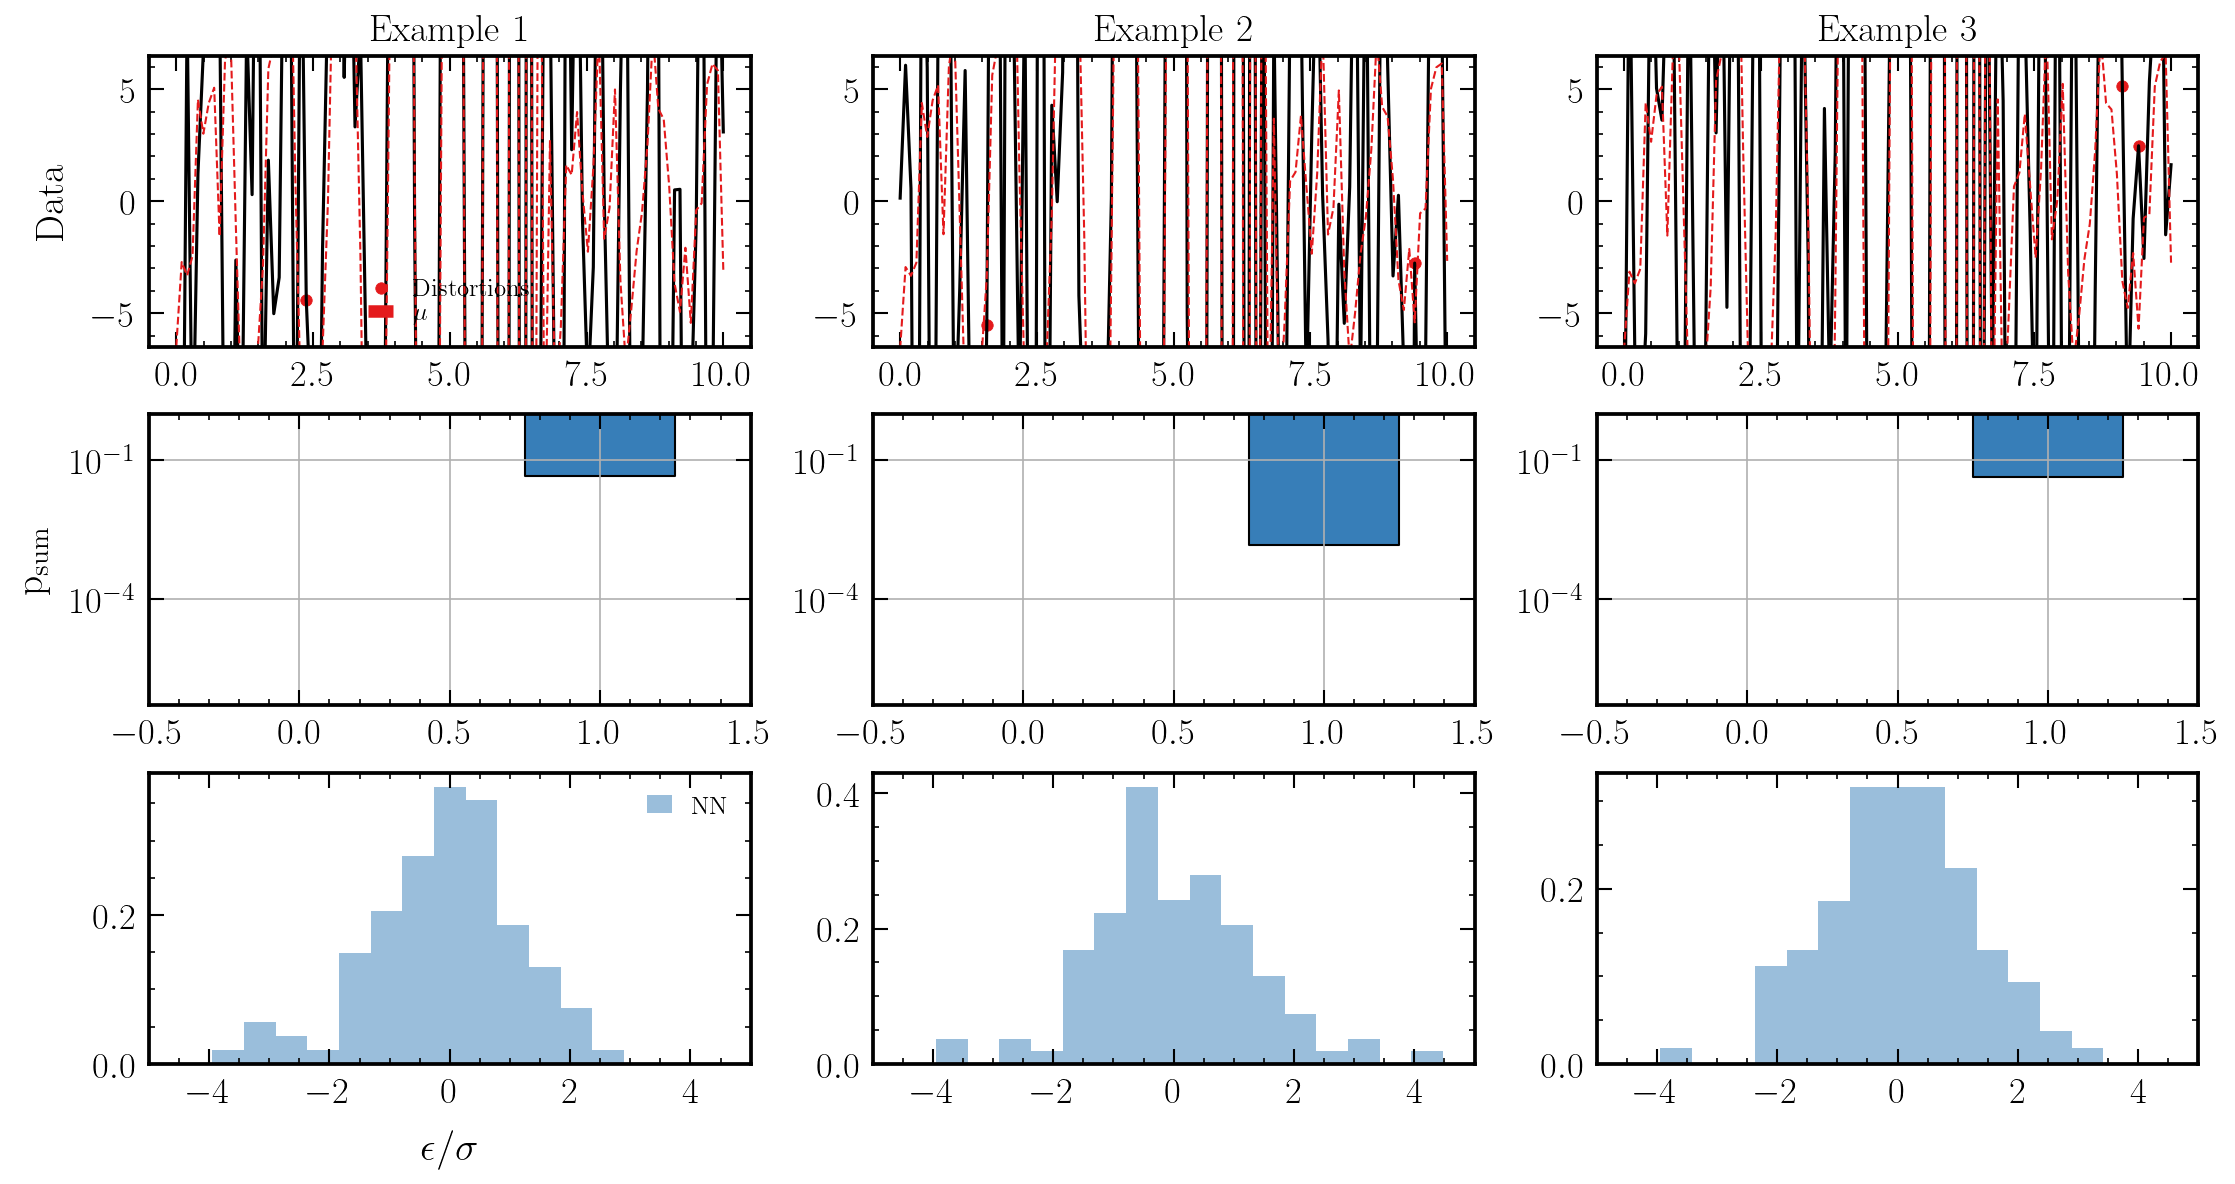

In [15]:
fig, axs = plt.subplots(3, 3, figsize=(15, 8), dpi=150)
for i in range(3):
    
    # Get sample
    obs = simulator.sample(1) 
    
    # Evaluate epsilon and SNR^2 test statistic from NN
    epsilon_nn = network_SNR.epsilon(obs['xi'].cuda()).detach().cpu().numpy().squeeze(0)
    snr2_nn = network_SNR.snr(obs['xi'].cuda()).detach().cpu().numpy().squeeze(0)**2
    variance_nn = network_SNR.logvariance.exp().detach().cpu().numpy()
    ts_sum_nn = snr2_nn.sum()-ts_sum_H0_SNR_mean
    p_sum_nn = t_to_pvalue_empirical(ts_sum_nn, ts_sum_H0_SNR)   
    
    # Plotting
    x = obs['xi'][0]
    ni = obs['ni'][0] 
    epsilon = obs['epsilon'][0] 
    grid = torch.linspace(0, 10, len(x))
    
    axs[0, i].plot(grid, obs['xi'][0], c='k')
    axs[0, i].scatter(grid[ni!=0], y=x[ni!=0], c='C0', s=30, marker='o',linewidths=0.4)
    axs[0, i].plot(grid, obs['mu'][0], c='C0', ls='--', lw=1)
    axs[0, i].set_title(f"Example {i+1}")
    axs[0, i].set_ylim(-6.5, 6.5)
    
    axs[1, i].set_yscale('log')
    axs[1, i].set_ylim(1/(N_mc*2), 1)
    axs[1, i].set_xlim(-0.5, 2 - 0.5)
    axs[1, i].grid(True)
    axs[1, i].fill_between([1 - 0.5 / 2, 1 + 0.5 / 2], 1, p_sum_nn, facecolor='C1', edgecolor='black')
    
    bins = np.linspace(-5, 5, int(Nbins/5))
    axs[2, i].hist(epsilon_nn/np.sqrt(variance_nn), bins=bins, density=True, color='C1', alpha=0.5, label='NN')
    axs[2, i].set_xlim(-5, 5)
    
axs[0, 0].scatter([],[], c='C0', s=30, marker='o',linewidths=0.4, label='Distortions')
axs[0, 0].plot([],[], c='C0', ls='--', lw=1, label=r'$\mu$')
axs[0, 0].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[0, 0].set_ylabel("Data")
axs[1, 0].set_ylabel("$\mathrm{p}_\mathrm{sum}$")
axs[2, 0].set_xlabel("$\epsilon / \sigma$")
axs[2, 0].legend(loc='best', fontsize=12, labelspacing=0.1)

plt.tight_layout();

---

### Global deviations test

Trial correct for the fact that we looked Nbins times + aggregated tests. What’s the overall significance given I’ve looked so many times? Each of the trials is one test.


In [16]:
ts_bin_H0_SNR.shape, ts_sum_H0_SNR.shape

((999424, 102), (999424,))

Compute p-values for the individual tests (Nbins)

In [17]:
N_mc, num_bins = ts_bin_H0_SNR.shape
ts_bin_flat = ts_bin_H0_SNR.reshape(N_mc, num_bins)
means = ts_bin_flat.mean(axis=0)  # Shape: [num_bins]
ts_centered = ts_bin_flat - means  # Shape: [N_mc, num_bins]

# Sort the centered data along N_mc axis
sorted_ts = np.sort(ts_centered, axis=0)  # Shape: [N_mc, num_bins]
# Compute ranks for all values
ranks = np.argsort(np.argsort(-ts_centered, axis=0), axis=0)  # Ranks in descending order
# Compute p-values
p_values = (ranks + 1) / N_mc
# Reshape back to [N_mc, num_bins]
pv_bin_H0 = p_values.reshape(N_mc, num_bins)    
    
pv_bin_H0.shape

(999424, 102)

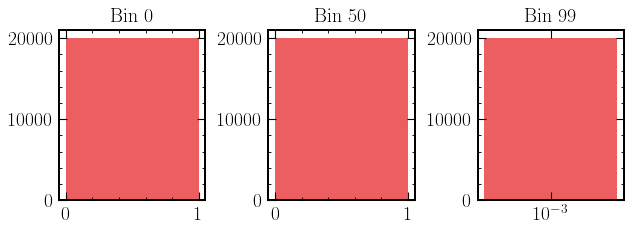

In [18]:
# p-values are uniformly distribute

selected_bins = [0, 50, 99]            # Bins to plot
fig, axs = plt.subplots(1, len(selected_bins), figsize=(8, 3))
for j, bin_idx in enumerate(selected_bins):
    pv_data = pv_bin_H0[:, bin_idx]
    axs[j].hist(pv_data, bins=50, alpha=0.7)
    axs[j].set_title(f'Bin {bin_idx}')
    axs[i].set_xscale('log')

plt.tight_layout()
plt.show()

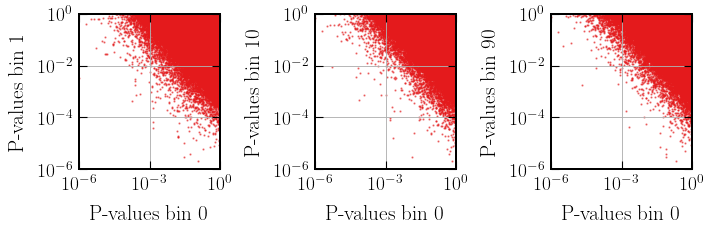

In [19]:
# p-values between different tests are correlated

bins_pairs = [(0, 1), (0, 10), (0, 90)]

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i, (bin1, bin2) in enumerate(bins_pairs):
    p_values_res1 = pv_bin_H0[:, bin1]
    p_values_res2 = pv_bin_H0[:, bin2]

    axs[i].scatter(p_values_res1, p_values_res2, alpha=0.5, s=1)
    axs[i].set_xlabel(f'P-values bin {bin1}')
    axs[i].set_ylabel(f'P-values bin {bin2}')
    axs[i].set_xlim(1e-6, 1)
    axs[i].set_ylim(1e-6, 1)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].grid(True)

plt.tight_layout()
plt.show()


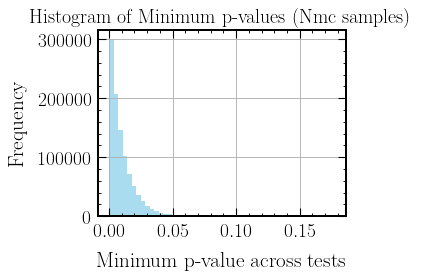

In [20]:
# MINIMUM

Nmc = pv_bin_H0.shape[0]
min_pv_bin_H0_SNR = np.min(pv_bin_H0.reshape(Nmc, -1), axis=1)  # Shape: [Nmc]

plt.figure(figsize=(4, 3))
plt.hist(min_pv_bin_H0_SNR, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Minimum p-value across tests')
plt.ylabel('Frequency')
plt.title('Histogram of Minimum p-values (Nmc samples)')
plt.grid(True)
plt.show()


Compute p-values for the total tests

In [21]:
means = ts_sum_H0_SNR.mean(axis=0)  # Shape: [1]
ts_centered = ts_sum_H0_SNR - means  # Shape: [N_mc]
sorted_ts = np.sort(ts_centered, axis=0)  # Shape: [N_mc]
ranks = np.argsort(np.argsort(-ts_centered, axis=0), axis=0)  # Ranks in descending order
p_values = (ranks + 1) / N_mc
pv_sum_H0 = p_values
pv_sum_H0.shape

(999424,)

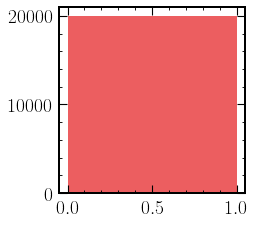

In [22]:
plt.figure(figsize=(3, 3))
plt.hist(pv_sum_H0, bins=50, alpha=0.7);

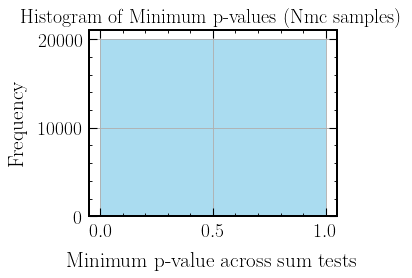

In [23]:
min_pv_sum_H0_SNR = np.min(pv_sum_H0.reshape(Nmc, -1), axis=1)  # Shape: [Nmc]

plt.figure(figsize=(4, 3))
plt.hist(min_pv_sum_H0_SNR, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Minimum p-value across sum tests')
plt.ylabel('Frequency')
plt.title('Histogram of Minimum p-values (Nmc samples)')
plt.grid(True)
plt.show()


Consider all tests

(999424, 103)


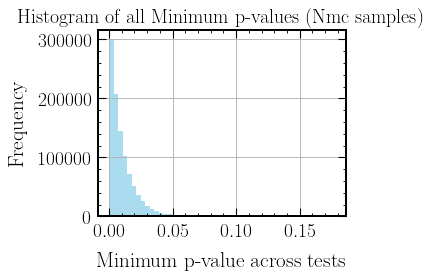

In [24]:
# MINIMUM

Nmc = pv_bin_H0.shape[0]
pv_all_H0 = np.concatenate([pv_bin_H0.reshape(Nmc, -1), pv_sum_H0.reshape(Nmc, -1)], axis=1)  # Shape: [Nmc, num_bins + 1]
print(pv_all_H0.shape)

min_pv_all_H0_SNR = np.min(pv_all_H0, axis=1)  # Shape: [Nmc]

plt.figure(figsize=(4, 3))
plt.hist(min_pv_all_H0_SNR, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Minimum p-value across tests')
plt.ylabel('Frequency')
plt.title('Histogram of all Minimum p-values (Nmc samples)')
plt.grid(True)
plt.show()


In [25]:
ts_bin_H0_SNR.shape, ts_sum_H0_SNR.shape

((999424, 102), (999424,))

---

### Summary plot

In [26]:
def analyse_SNR(obs):

    epsilon_nn = network_SNR.epsilon(obs['xi'].cuda()).detach().cpu().numpy().squeeze(0)
    variance_nn = network_SNR.logvariance.exp().detach().cpu().numpy()
    snr2_nn = network_SNR.snr(obs['xi'].cuda()).detach().cpu().numpy().squeeze(0)**2
    ts_sum_nn = snr2_nn.sum()-ts_sum_H0_SNR_mean
    p_sum_nn = t_to_pvalue_empirical(ts_sum_nn, ts_sum_H0_SNR)   

    # Compute localized p-values
    _p_nn = []
    for idx, ts_bin in enumerate(snr2_nn):
        ts_bin_i = ts_bin_H0_SNR[:, idx]
        m = ts_bin_i.mean()
        ts0_ref = ts_bin_i - m
        ts_obs = (ts_bin-m)
        _p_nn.append(t_to_pvalue_empirical(ts_obs, ts0_ref))  
    p_nn = np.array(_p_nn) 

    # Compute global p-values
    obs_min_pv_bin = p_nn.reshape(-1).min()
    obs_min_pv_sum = p_sum_nn
    pv_all_obs = np.concatenate([
        p_nn.reshape(-1),  # Shape: [Nbins]
        torch.tensor([p_sum_nn])  # Shape: [1]
    ], axis=0)  # Combined shape: [num_total_tests]
    obs_min_pv_all = pv_all_obs.min()

    p_glob_bin_SNR = np.mean(min_pv_bin_H0_SNR <= obs_min_pv_bin)
    p_glob_all_SNR = np.mean(min_pv_all_H0_SNR <= obs_min_pv_all)

    return epsilon_nn, variance_nn, snr2_nn, p_nn, p_sum_nn, p_glob_all_SNR


def plot_SNR(obs, epsilon_nn, variance_nn, snr2_nn, p_nn, p_sum_nn, p_glob_all_SNR, real=False):
    
    # Figure
    mygold = (218/255, 165/255, 32/255, 0.1)  
    fig = plt.figure(figsize=(10, 8), dpi=250)
    gs = plt.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1], width_ratios=[2, 1], hspace=0.3, wspace=0.3)

    # First row: ax1 spans both columns
    ax1 = fig.add_subplot(gs[0, 0])
    xi = obs['xi'][0]
    grid = times
    if real:
        ax1.plot(grid, obs['xi'][0], color='k', label="$x_{\mathrm{obs}}$")
        ax1.set_title("GW150814")
    else:
        ni = obs['ni'][0] 
        dist = obs['xi'][0] - obs['x0'][0]
        epsilon = obs['epsilon'][0] 
        ax1.plot(grid, obs['mu'][0], color='k', label="$\mu_{\mathrm{sim}}$")
        ax1.plot(grid, obs['mu'][0]+dist, color='C1', label="$\mu_{\mathrm{dist B}}$")
        ax1.fill_between(grid, obs['mu'][0], obs['mu'][0]+dist, color='C1', alpha=0.5)
        ax1.scatter(grid, xi, color='k', marker='x', s=6)
        ax1.set_title("Data")
        ax1.legend(fontsize=12, bbox_to_anchor=[0.6,0.65,0,0], labelspacing=0.1)
    ax1.set_ylabel("$x_\mathrm{obs}$", labelpad=1.5)
    ax1.set_xticks([])

    # Second column: ax2 and ax3 in the first column
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.semilogy(grid, p_nn, c='C1', label=r"$\textsc{SBI}$")
    ax2.set_ylabel("$\mathrm{p}_\mathrm{obs}$", labelpad=1.5)
    ax2.legend(loc='best',  fontsize=13)
    ax2.set_ylim(1/(N_mc*5), 1)
    ax2.set_xticks([])
    ax2.set_title("Anomaly detection")
    ax2.grid(True, axis='y')
    ax2.set_xticks([])

    ax3 = fig.add_subplot(gs[2, 0])
    # ax3.set_facecolor(dandelion)
    ax3.plot(grid, epsilon_nn, c='C1', label=r"$\textsc{SBI}$")
    ax3.set_ylabel(r"$\epsilon_\mathrm{obs}$")
    ax3.legend(loc='best',  fontsize=13)
    ax3.axhline(0, color='#b0b0b0', ls='--', lw=1)
    ax3.set_title("Residual analysis")
    # ax3.set_ylim(-6.5, 6.5)
    ax3.set_xticks([])

    # Second column: ax4 and ax6 in the second column
    # Bars
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_yscale('log')
    ax4.set_ylim(1/(N_mc*5), 1)
    ax4.set_xticks([0, 1])
    ax4.set_xticklabels(["SBI", "Analytical"])
    ax4.set_xlim(-0.5, 2 - 0.5)
    ax4.set_ylabel("$\mathrm{p}_\mathrm{sum}$")
    ax4.fill_between([-0.2, 0.2], 1, p_sum_nn, facecolor='C1', edgecolor='C1')
    ax4.grid(True, axis='y', which='both')
    ax4.set_title("Model validation")
    ax4.tick_params(axis="x",direction="in", pad=-25)
    ax4.minorticks_off()

    # Hist
    ax6 = fig.add_subplot(gs[2, 1])
    bins = np.linspace(-5, 5, int(Nbins/5))
    ax6.hist(epsilon_nn / np.sqrt(variance_nn), bins=bins, density=True, color='C1', alpha=0.5)
    ax6.set_xlim(-5, 5)
    ax6.set_xlabel("$\epsilon_\mathrm{obs} / \sigma$")
    ax6.set_title("Residual variance analysis")

    # Add on gs[0, 1] text reporting the three global p-values
    mantissa, exp = ('%.2e' % p_glob_all_SNR).split('e')
    exp = int(exp)
    textstr = r'$\mathrm{p}_{\mathrm{glob}}= %s \times 10^{%d}$' % (mantissa, exp)
    ax3.text(0.6, -0.4, textstr, transform=ax3.transAxes, fontsize=14,
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(
                    facecolor=mygold,
                    edgecolor='none'  # Remove the border if not needed
                )
            )
    ax3.text(0.2, -0.4, "Global p-value", transform=ax3.transAxes, fontsize=18,
                verticalalignment='center', horizontalalignment='center')


Loading data for H1 at GPS time 1126259462.4
Loading PSD for H1 at GPS time 1126259462.4 [can take O(1 min)]
Loading posterior samples from GW150814_posterior_samples.npz


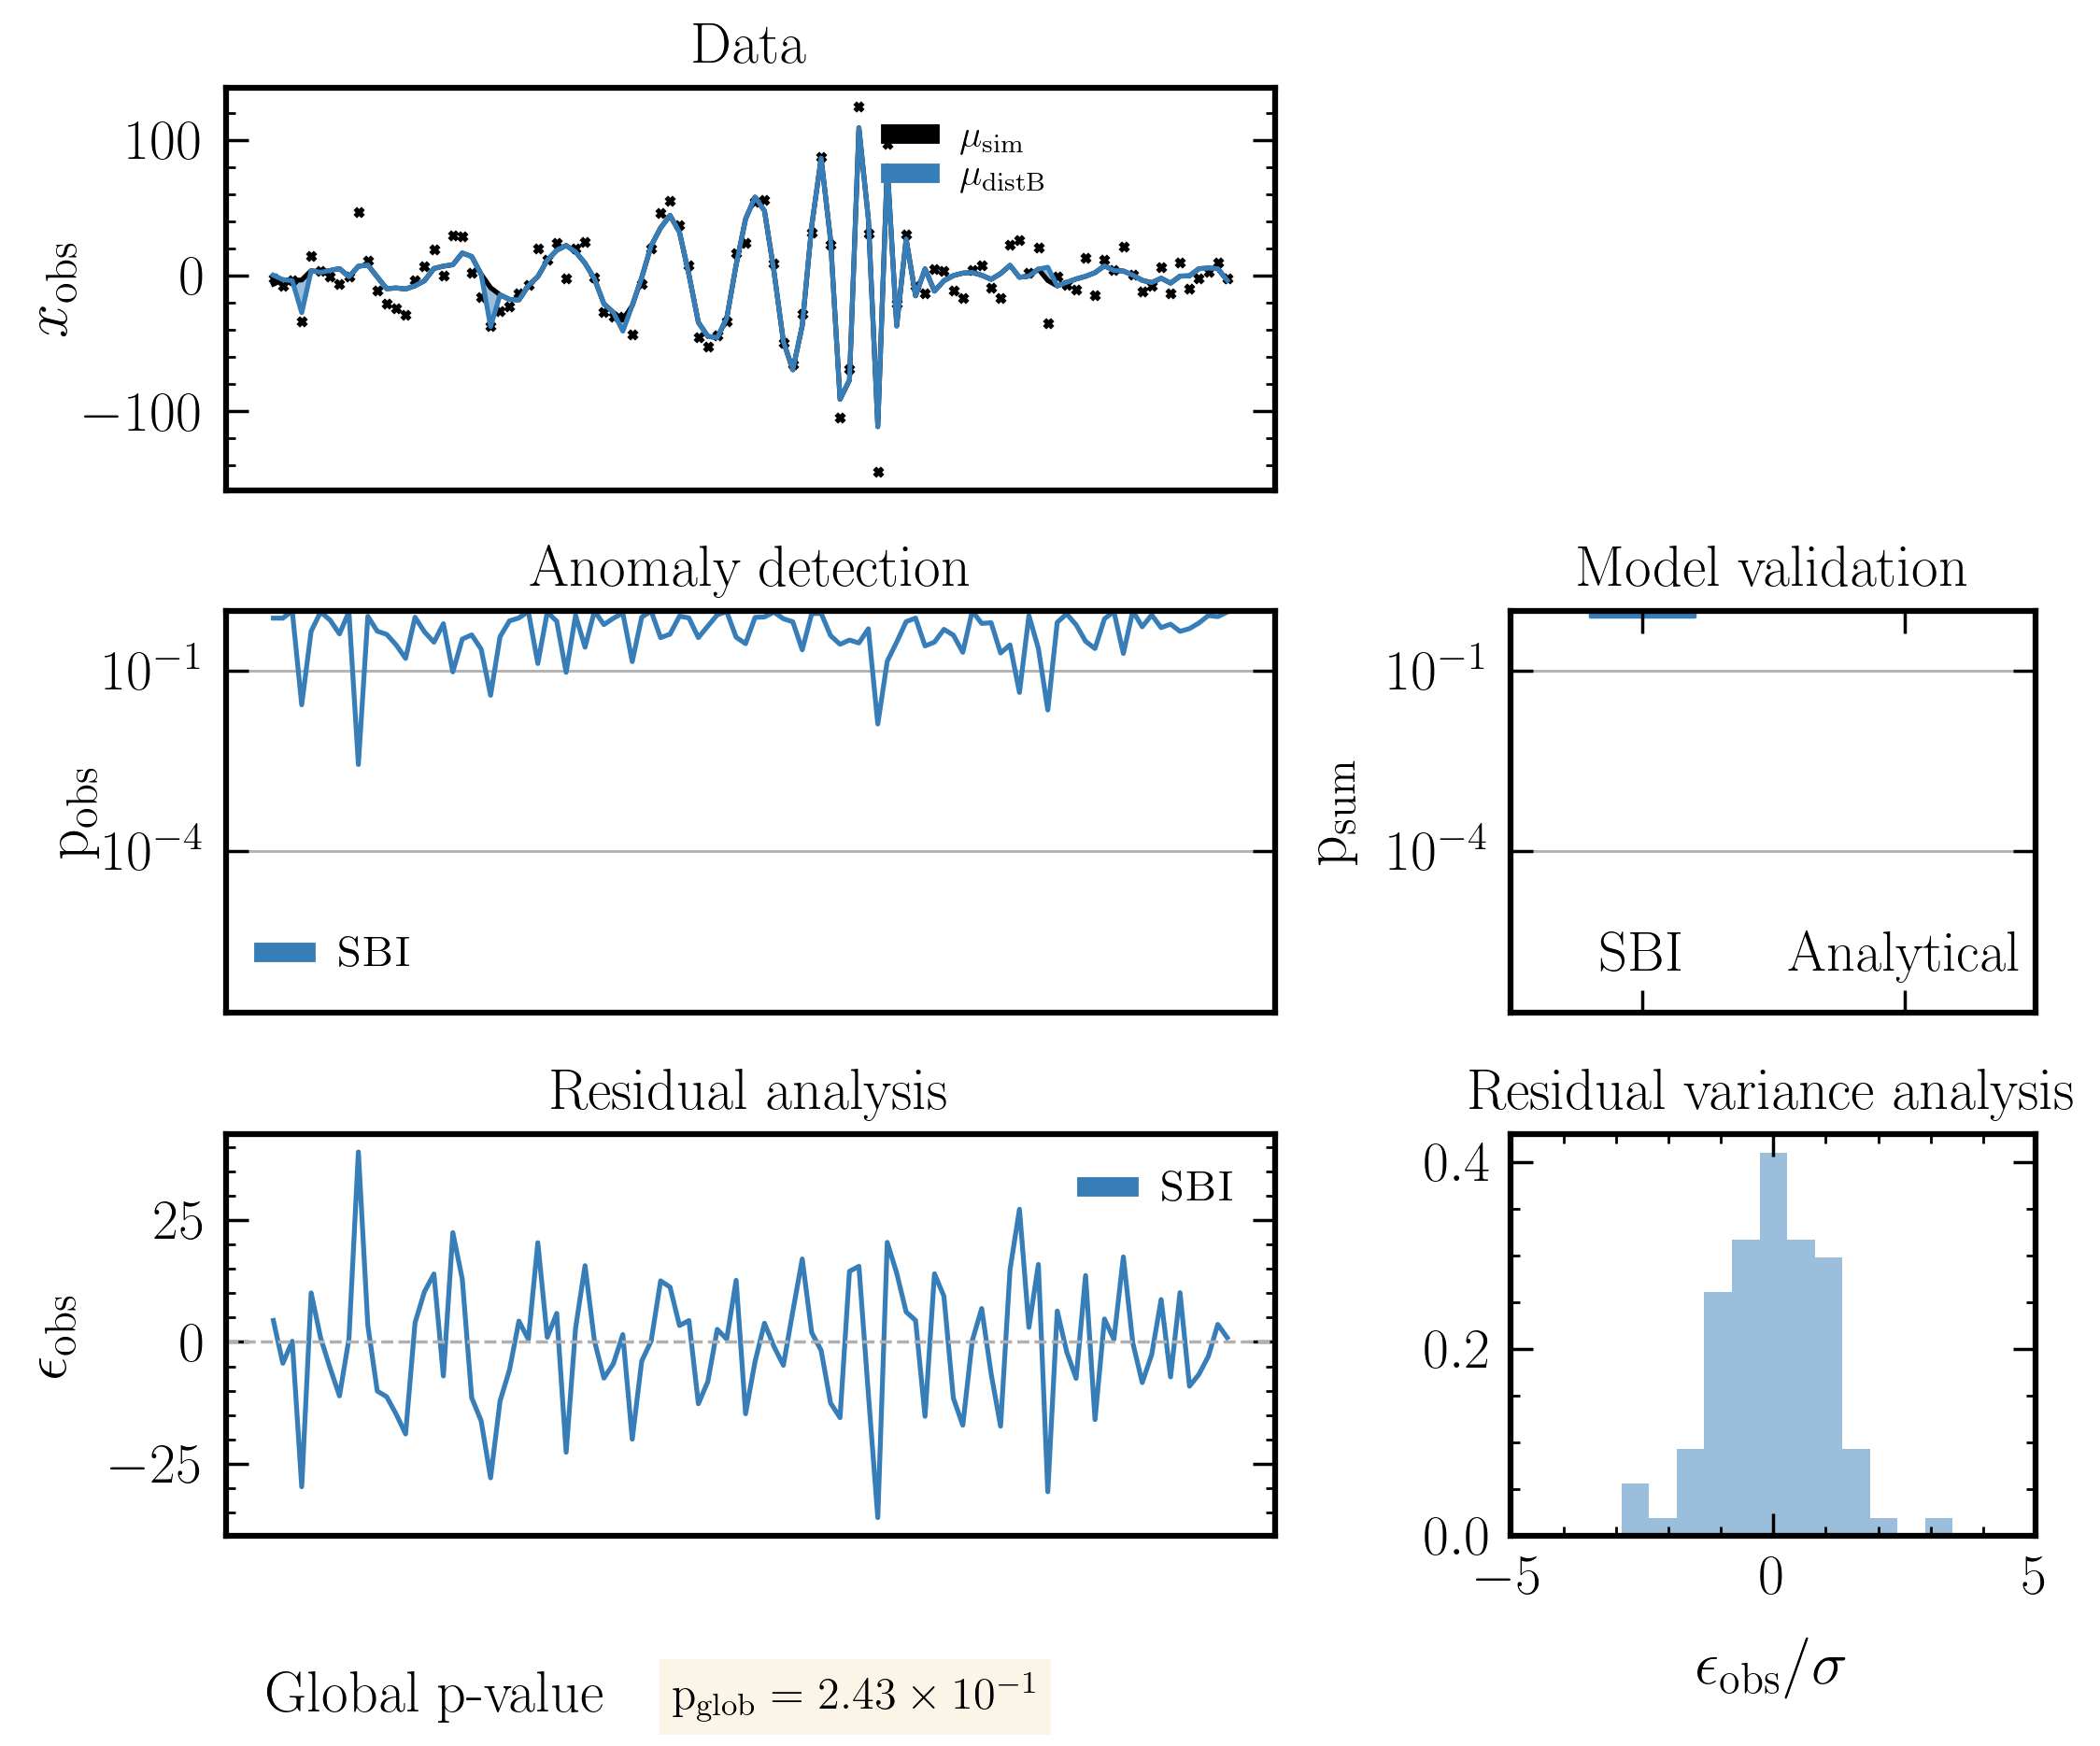

In [27]:
# OBS
simulator1 = GW150814_Additive(gw150814_samples=gw150814_samples, bounds=bounds, dtype=torch.float32, fraction=0.05) #    # Just one bin is distorted with fraction=None  
obs = simulator1.sample(1) 
# obs = torch.load("figures/test0.pt")

epsilon_nn, variance_nn, snr2_nn, p_nn_SNR, p_sum_nn_SNR, p_glob_all_SNR = analyse_SNR(obs)

plot_SNR(obs, epsilon_nn, variance_nn, snr2_nn, p_nn_SNR, p_sum_nn_SNR, p_glob_all_SNR)
# plt.savefig("figures/plot_test0_bin_epsilon_f.1.png", dpi=300, transparent=True)

/home/noemiam/sbi/gofish/GW/gw150814_simulator.py:232: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
  return torch.from_numpy(np.asarray(data))


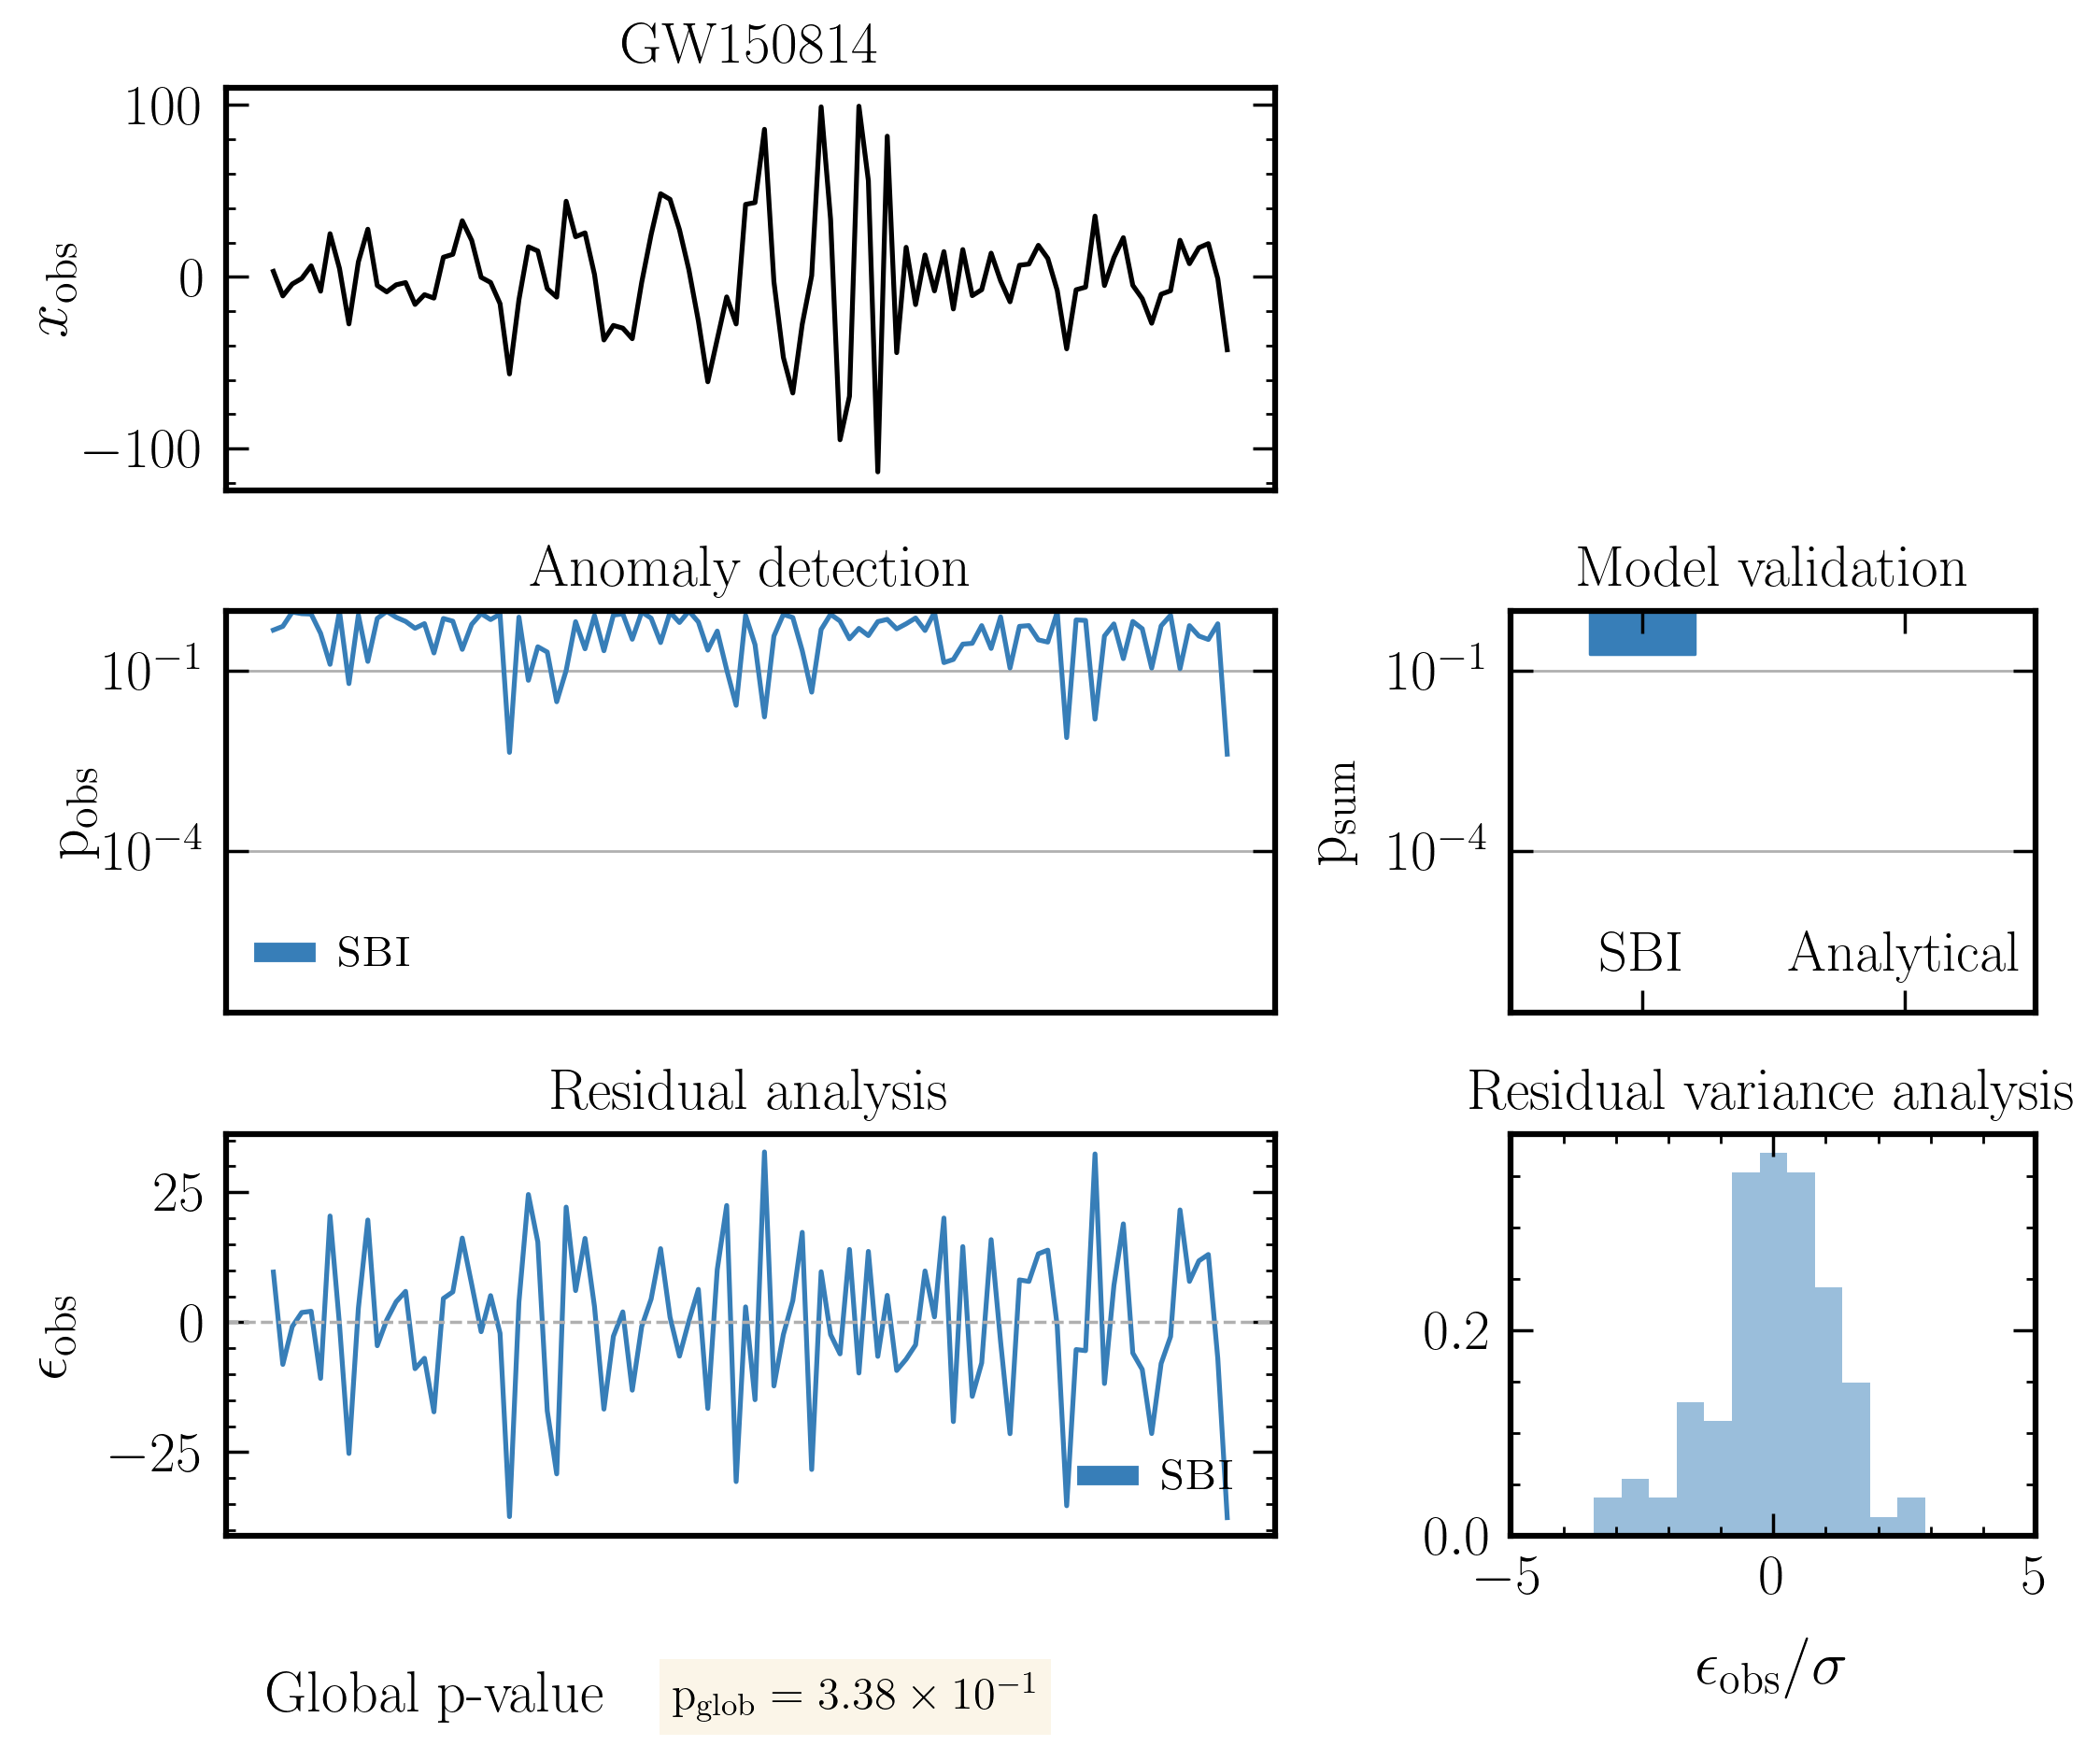

In [28]:
# REAL DATA
gw150814 = simulator._jax_to_torch(simulator._process(simulator.filter_gwosc_data()))
obs = {'xi': gw150814.unsqueeze(0).to(torch.float32)}

epsilon_nn, variance_nn, snr2_nn, p_nn_SNR, p_sum_nn_SNR, p_glob_all_SNR = analyse_SNR(obs)
plot_SNR(obs, epsilon_nn, variance_nn, snr2_nn, p_nn_SNR, p_sum_nn_SNR, p_glob_all_SNR, real=True)


## Training BCE

In [29]:
bounds = network_SNR.bounds().detach().cpu().numpy().item()
simulator = GW150814_Additive(gw150814_samples=gw150814_samples, bounds=bounds, dtype=torch.float32, fraction=0.5)

bounds

Loading data for H1 at GPS time 1126259462.4


Loading PSD for H1 at GPS time 1126259462.4 [can take O(1 min)]
Loading posterior samples from GW150814_posterior_samples.npz


62.4174690246582

In [30]:
from models.resnet_1d import ResidualNet 
from models.online_norm import OnlineStandardizingLayer

class Network_BCE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = ResidualNet(1, 1, hidden_features=128, num_blocks=2, kernel_size=1, padding=0)  
        self.online_norm = OnlineStandardizingLayer((Nbins,), use_average_std=False) 

    def forward(self, x):
        data = x['x']
        data = self.online_norm(data)
        x = self.net(data.unsqueeze(1)).squeeze(1)
        return x

In [31]:
# Train
def resample(sample):
    sample = simulator._resample(sample)
    sample['x'] = sample['xi']
    sample = {k: v for k, v in sample.items()}
    return sample

batch_size = 128
# dm = StoredDataModule(samples, batch_size=batch_size, on_after_load_sample=resample)
dm = OnTheFlyDataModule(simulator, Nsims_per_epoch=400*batch_size, batch_size=batch_size)
network_BCE = Network_BCE()
model = BCELossModule(network_BCE, learning_rate=5e-3)
trainer = pl.Trainer(
    accelerator="gpu", 
    max_epochs=100, 
    precision=64,
    # fast_dev_run=True
)
trainer.fit(model, dm)
network_BCE.cuda().eval();

/home/noemiam/.pyenv/versions/swyft-3.10.0/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/noemiam/.pyenv/versions/swyft-3.10.0/lib/pytho ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float

Sanity Checking: 0it [00:00, ?it/s]

/home/noemiam/.pyenv/versions/swyft-3.10.0/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/noemiam/.pyenv/versions/swyft-3.10.0/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.470


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.470


Epoch 00007: reducing learning rate of group 0 to 2.5000e-03.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.470


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.470


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.470


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.470


Validation: 0it [00:00, ?it/s]

Epoch 00020: reducing learning rate of group 0 to 1.2500e-03.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.470


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.470


Epoch 00027: reducing learning rate of group 0 to 6.2500e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00033: reducing learning rate of group 0 to 3.1250e-04.


Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.470. Signaling Trainer to stop.


Reloading best model: /home/noemiam/sbi/gofish/GW/lightning_logs/version_44/checkpoints/epoch=26-val_loss=0.47.ckpt


---

## Evaluate BCE

Define test statistic

$TS(x) = - 2 \log\frac{p(x|H_0)}{p(x|H_1)} = 2 f_\phi(x)$

In [32]:
def ts_sbi(x: dict, model: int =0):
    # x = dict_to_double(x)
    x = dict_to_cuda(x)
    
    # Test statistic for sample 0 or 1
    if 'x' not in x.keys():
        if model == 0:
            x['x'] = x['x0']
        elif model == 1:
            x['x'] = x['xi'] 

    # Test statistic
    t = 2 * (network_BCE(x).detach().cpu().squeeze(0).numpy())
    
    # Go back to cpu 
    x = dict_to_cpu(x)
    return t

#### Monte-Carlo H0

In [33]:
N_mc = 1e6

# if os.path.exists("ts_bin_H0_BCE_2.npy"):
#     ts_bin_H0_BCE = np.load("ts_bin_H0_BCE_2.npy")
# else:
batch_size = 2048*2
N_batch = int(N_mc / batch_size)
ts_bin_H0_BCE = []
for _ in tqdm(range(N_batch)):
    mc_samples = simulator.sample(batch_size)
    ts_bin_H0_BCE.append(ts_sbi(mc_samples, model=0))
ts_bin_H0_BCE = np.concatenate(ts_bin_H0_BCE)
# np.save("ts_bin_H0_BCE_2.npy", ts_bin_H0_BCE)

ts_bin_H0_BCE.shape

  0%|          | 0/244 [00:00<?, ?it/s]

100%|██████████| 244/244 [03:00<00:00,  1.35it/s]


(999424, 102)

Histogram of $t_i | H_0$ in individual bins

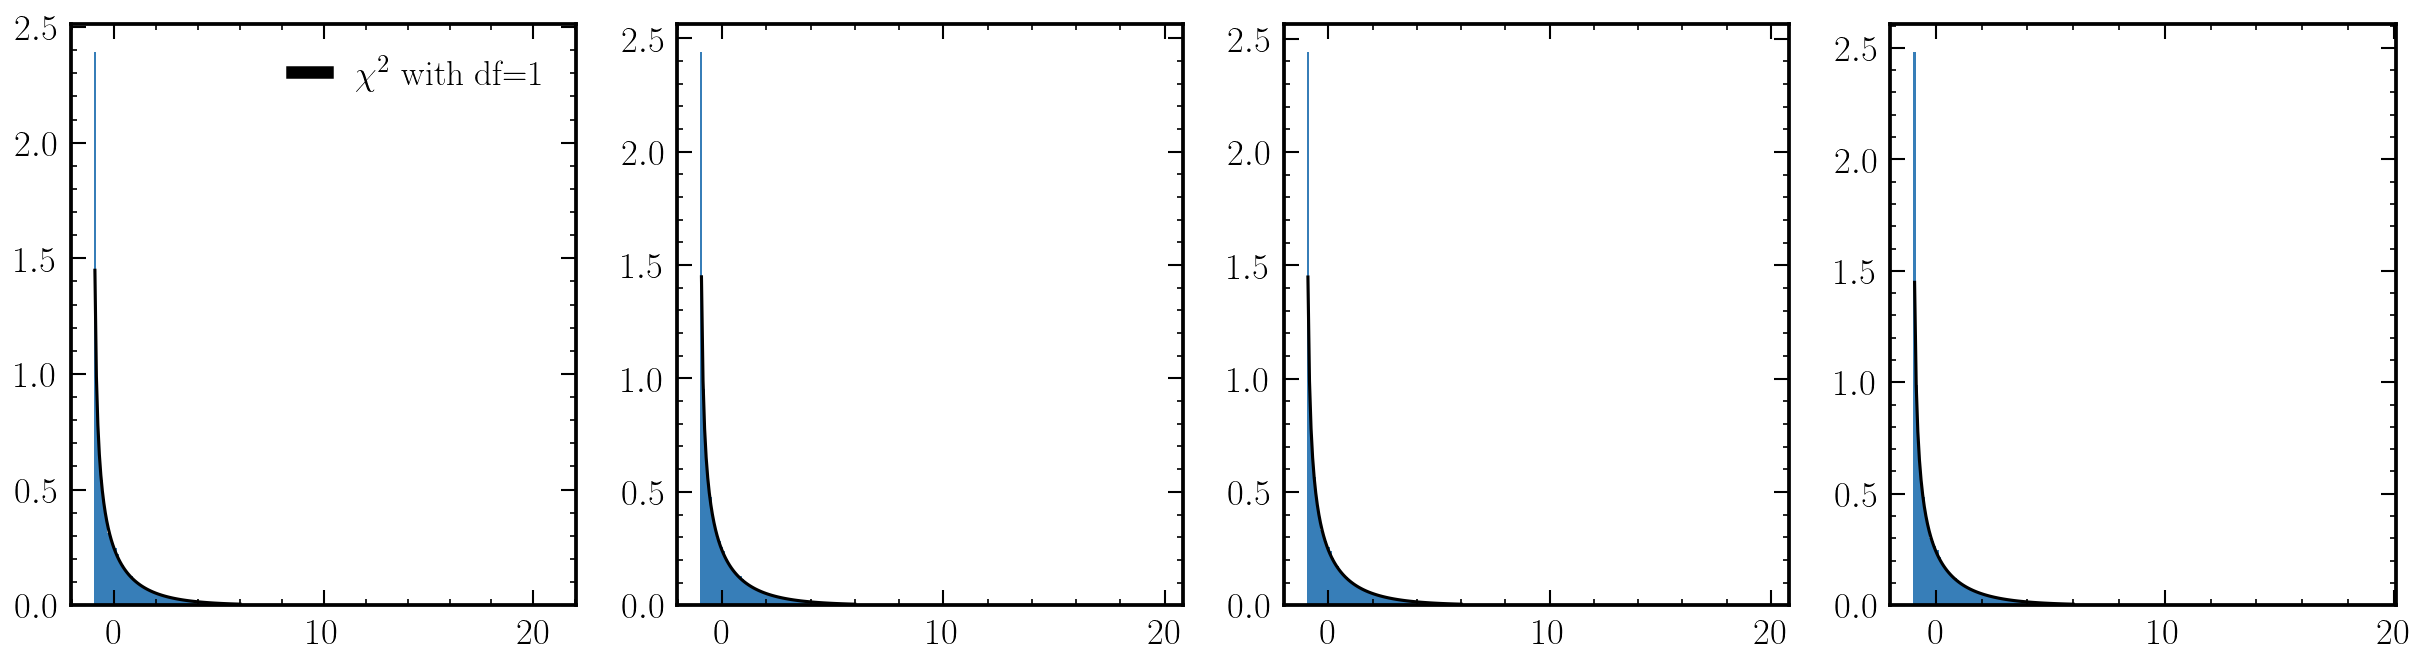

In [34]:
# Compare with chi2 with df = 1
grid = np.linspace(-1, 6, 100) # 1 df, adjust
chi2 = scipy.stats.chi2.pdf(grid, df=1, loc=-1)

fig, axs = plt.subplots(1, 4, figsize=(20, 5), dpi=150)
for i in range(4):
    bin = torch.randint(Nbins, (1,))
    ts_bin_i = ts_bin_H0_BCE[:, bin]
    m = ts_bin_i.mean()
    axs[i].plot(grid, chi2, c='k', label='$\chi^2$ with df=1')
    axs[i].hist(ts_bin_i-m, bins=200, density=True, color='C1')
axs[0].legend();

---

### Individual deviations test

- Localized $t_i$
- Localized $\mathrm{p}_i$ for anomaly detection

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


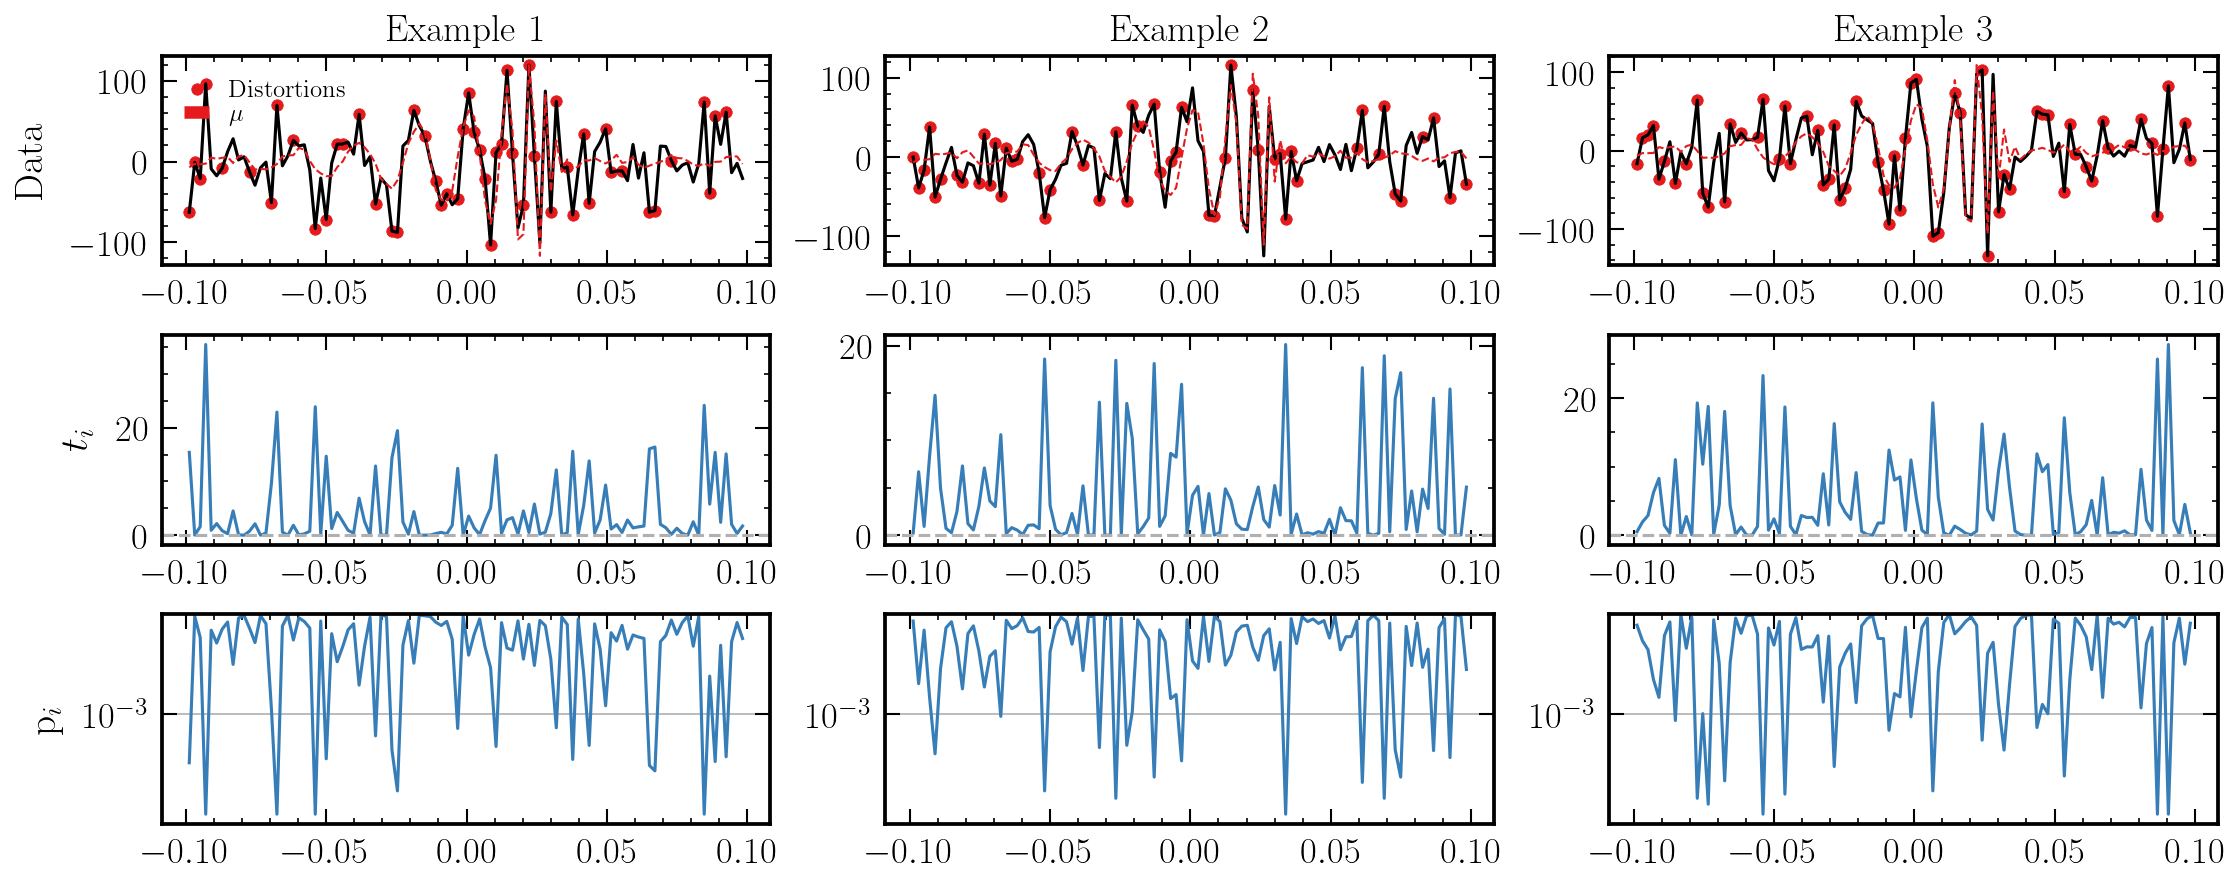

In [35]:
fig, axs = plt.subplots(3, 3, figsize=(15, 6), dpi=150)
for i in range(3):
    
    # Get sample
    obs = simulator.sample(1) 
    ts_bin_obs = ts_sbi(obs, model=1)
    
    # Compute p-values
    _p_nn = []
    for idx, ts_bin in enumerate(ts_bin_obs):
        ts_bin_i = ts_bin_H0_BCE[:, idx]
        m = ts_bin_i.mean()
        ts0_ref = ts_bin_i - m
        ts_obs = (ts_bin-m)
        _p_nn.append(t_to_pvalue_empirical(ts_obs, ts0_ref))  
    p_nn = np.array(_p_nn) 
    
    # Plotting
    x = obs['xi'][0]
    ni = obs['ni'][0]
    grid = times
    
    axs[0, i].plot(grid, obs['xi'][0], c='k')
    axs[0, i].scatter(grid[ni!=0], y=x[ni!=0], c='C0', s=30, marker='o',linewidths=0.4)
    axs[0, i].plot(grid, obs['mu'][0], c='C0', ls='--', lw=1)
    axs[0, i].set_title(f"Example {i+1}")
    # axs[0, i].set_ylim(-6.5, 6.5)

    axs[1, i].plot(grid, ts_bin_obs-ts_bin_obs.min(), c='C1')
    # axs[1, i].set_ylim(-6.5, 6.5)
    axs[1, i].axhline(0, color='#b0b0b0', linestyle='--')

    axs[2, i].semilogy(grid, p_nn, c='C1')
    axs[2, i].set_ylim(1/N_mc/2, 1)
    axs[2, i].grid(True, axis='y')
    
    
axs[0, 0].scatter([],[], c='C0', s=30, marker='o',linewidths=0.4, label='Distortions')
axs[0, 0].plot([],[], c='C0', ls='--', lw=1, label=r'$\mu$')
axs[0, 0].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[0, 0].set_ylabel("Data")
axs[1, 0].set_ylabel(r"$t_i$")
axs[1, 0].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[2, 0].set_ylabel("$\mathrm{p}_i$")
plt.tight_layout();


---

### Total deviations test

- Aggregated $t_{\rm sum}(x) = \sum_{i=1}^{N_{\rm alt}} - 2 \log\frac{p(x|H_0)}{p(x|H_i)} $
- Aggregated $\mathrm{p}_{\rm sum}$ for model validation

In [36]:
# From MCMC samples
ts_sum_H0_BCE = ts_bin_H0_BCE.sum(axis=1)
ts_sum_H0_BCE_mean = ts_sum_H0_BCE.mean()
ts_sum_H0_BCE = ts_sum_H0_BCE - ts_sum_H0_BCE_mean

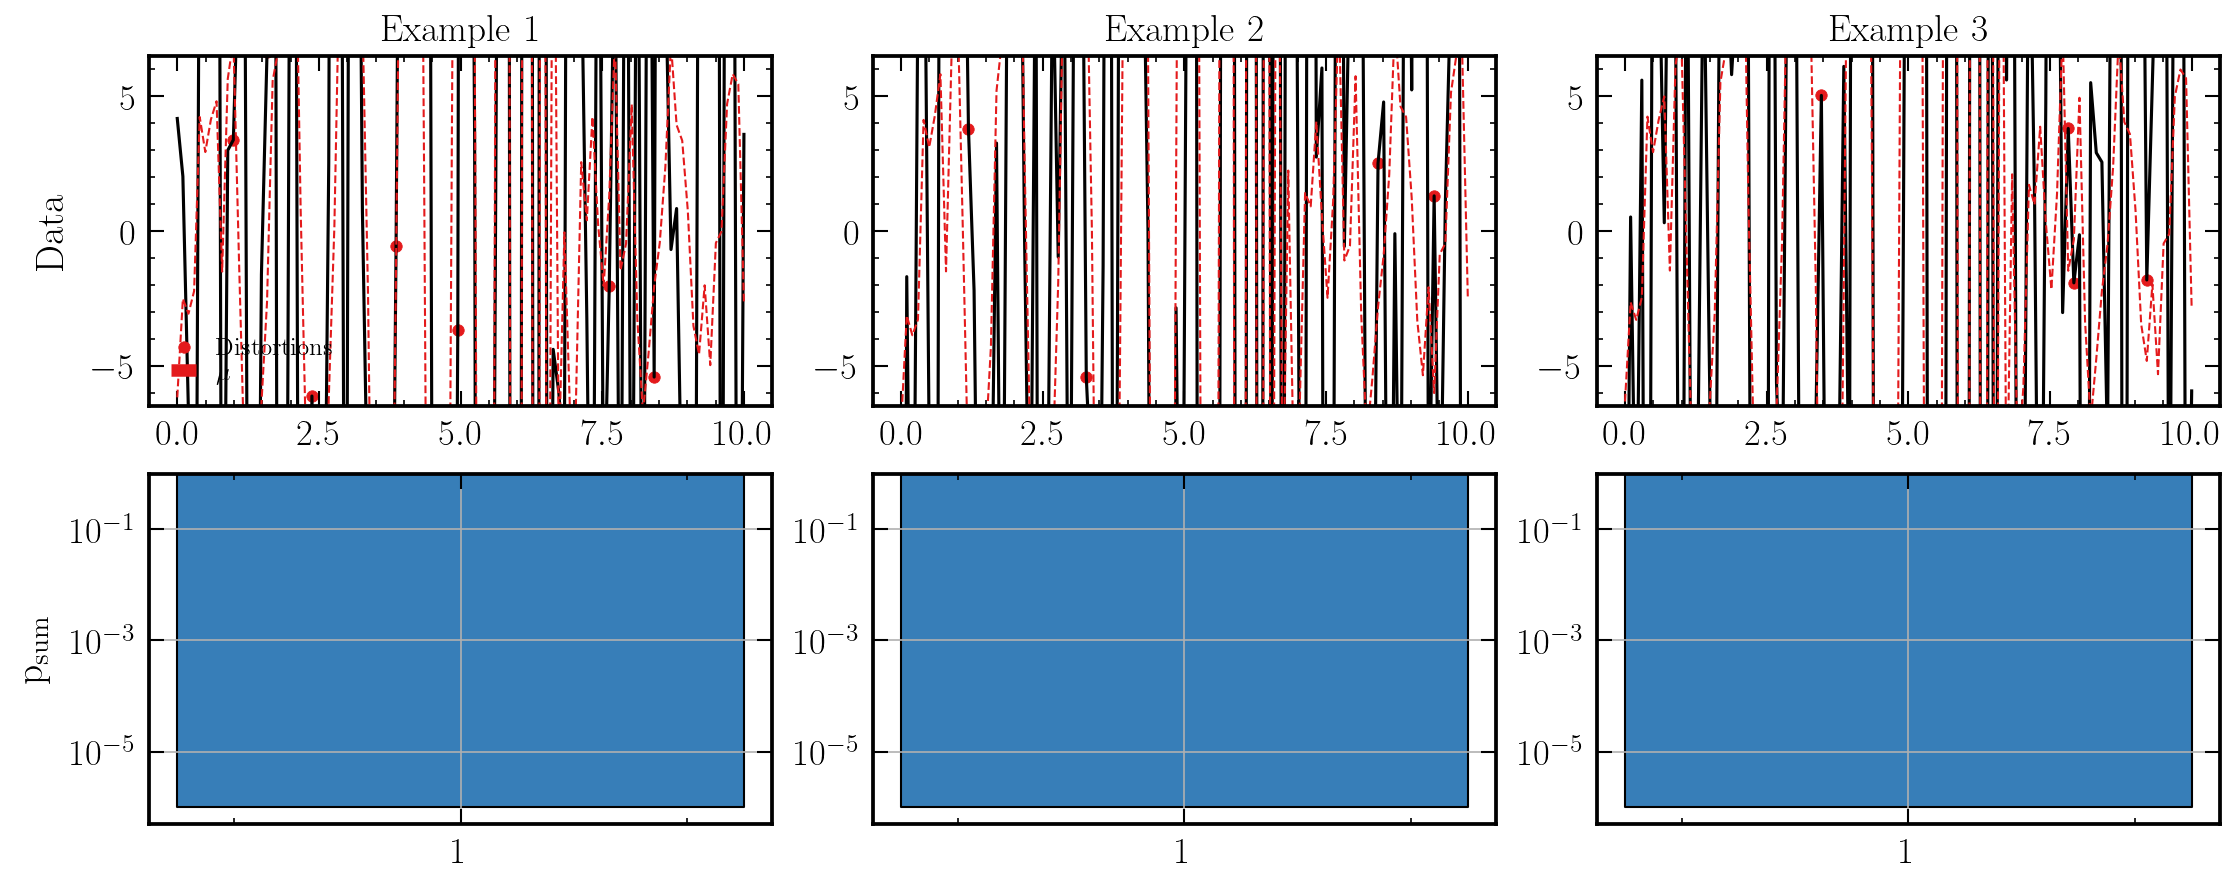

In [37]:
fig, axs = plt.subplots(2, 3, figsize=(15, 6), dpi=150)
for i in range(3):
    
    # Get sample
    obs = simulator.sample(1) 
    ts_bin_obs = ts_sbi(obs, model=1)
    ts_sum_obs = ts_bin_obs.sum()-ts_sum_H0_BCE_mean
    p_obs = t_to_pvalue_empirical(ts_sum_obs, ts_sum_H0_BCE)
    
    # Plotting
    x = obs['xi'][0]
    ni = obs['ni'][0] 
    grid = torch.linspace(0, 10, len(x))
    
    axs[0, i].plot(grid, obs['xi'][0], c='k')
    axs[0, i].scatter(grid[ni!=0], y=x[ni!=0], c='C0', s=30, marker='o',linewidths=0.4)
    axs[0, i].plot(grid, obs['mu'][0], c='C0', ls='--', lw=1)
    axs[0, i].set_title(f"Example {i+1}")
    axs[0, i].set_ylim(-6.5, 6.5)
    
    axs[1, i].set_yscale('log')
    axs[1, i].set_ylim(1/(N_mc*2), 1)
    axs[1, i].set_xticks([0, 1])
    axs[1, i].grid(True)
    axs[1, i].fill_between([1 - 0.5 / 2, 1 + 0.5 / 2], 1, p_obs, facecolor='C1', edgecolor='black')
        
axs[0, 0].scatter([],[], c='C0', s=30, marker='o',linewidths=0.4, label='Distortions')
axs[0, 0].plot([],[], c='C0', ls='--', lw=1, label=r'$\mu$')
axs[0, 0].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[0, 0].set_ylabel("Data")
axs[1, 0].set_ylabel("$\mathrm{p}_\mathrm{sum}$")

plt.tight_layout();

---

### Global deviations test

Trial correct for the fact that we looked Nbins times + aggregated tests. What’s the overall significance given I’ve looked so many times? Each of the trials is one test.


In [38]:
ts_bin_H0_BCE.shape, ts_sum_H0_BCE.shape

((999424, 102), (999424,))

Compute p-values for the individual tests (Nbins)

In [39]:
N_mc, num_bins = ts_bin_H0_BCE.shape
ts_bin_flat = ts_bin_H0_BCE.reshape(N_mc, num_bins)
means = ts_bin_flat.mean(axis=0)  # Shape: [num_bins]
ts_centered = ts_bin_flat - means  # Shape: [N_mc, num_bins]

# Sort the centered data along N_mc axis
sorted_ts = np.sort(ts_centered, axis=0)  # Shape: [N_mc, num_bins]
# Compute ranks for all values
ranks = np.argsort(np.argsort(-ts_centered, axis=0), axis=0)  # Ranks in descending order
# Compute p-values
p_values = (ranks + 1) / N_mc
# Reshape back to [N_mc, num_bins]
pv_bin_H0 = p_values.reshape(N_mc, num_bins)    
    
pv_bin_H0.shape

(999424, 102)

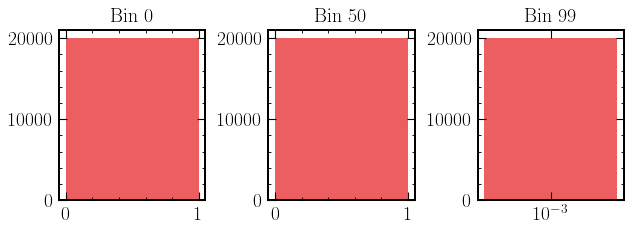

In [40]:
# p-values are uniformly distribute

selected_bins = [0, 50, 99]            # Bins to plot
fig, axs = plt.subplots(1, len(selected_bins), figsize=(8, 3))
for j, bin_idx in enumerate(selected_bins):
    pv_data = pv_bin_H0[:, bin_idx]
    axs[j].hist(pv_data, bins=50, alpha=0.7)
    axs[j].set_title(f'Bin {bin_idx}')
    axs[i].set_xscale('log')

plt.tight_layout()
plt.show()

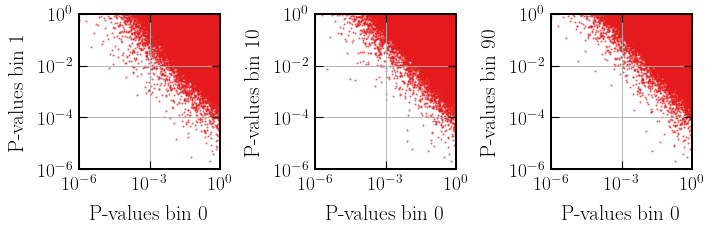

In [41]:
# p-values between different tests are correlated

bins_pairs = [(0, 1), (0, 10), (0, 90)]

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i, (bin1, bin2) in enumerate(bins_pairs):
    p_values_res1 = pv_bin_H0[:, bin1]
    p_values_res2 = pv_bin_H0[:, bin2]

    axs[i].scatter(p_values_res1, p_values_res2, alpha=0.5, s=1)
    axs[i].set_xlabel(f'P-values bin {bin1}')
    axs[i].set_ylabel(f'P-values bin {bin2}')
    axs[i].set_xlim(1e-6, 1)
    axs[i].set_ylim(1e-6, 1)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].grid(True)

plt.tight_layout()
plt.show()


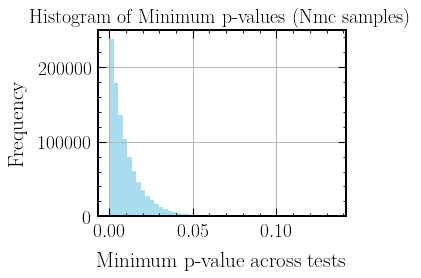

In [42]:
# MINIMUM

Nmc = pv_bin_H0.shape[0]
min_pv_bin_H0_BCE = np.min(pv_bin_H0.reshape(Nmc, -1), axis=1)  # Shape: [Nmc]

plt.figure(figsize=(4, 3))
plt.hist(min_pv_bin_H0_BCE, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Minimum p-value across tests')
plt.ylabel('Frequency')
plt.title('Histogram of Minimum p-values (Nmc samples)')
plt.grid(True)
plt.show()


Compute p-values for the total tests

In [43]:
means = ts_sum_H0_BCE.mean(axis=0)  # Shape: [1]
ts_centered = ts_sum_H0_BCE - means  # Shape: [N_mc]
sorted_ts = np.sort(ts_centered, axis=0)  # Shape: [N_mc]
ranks = np.argsort(np.argsort(-ts_centered, axis=0), axis=0)  # Ranks in descending order
p_values = (ranks + 1) / N_mc
pv_sum_H0 = p_values
pv_sum_H0.shape

(999424,)

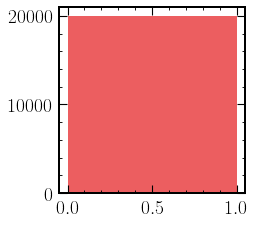

In [44]:
plt.figure(figsize=(3, 3))
plt.hist(pv_sum_H0, bins=50, alpha=0.7);

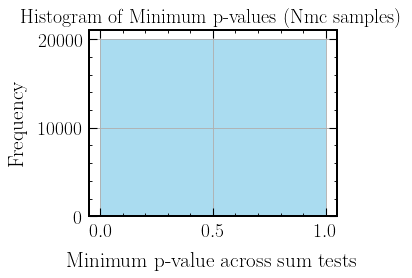

In [45]:
min_pv_sum_H0_BCE = np.min(pv_sum_H0.reshape(Nmc, -1), axis=1)  # Shape: [Nmc]

plt.figure(figsize=(4, 3))
plt.hist(min_pv_sum_H0_BCE, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Minimum p-value across sum tests')
plt.ylabel('Frequency')
plt.title('Histogram of Minimum p-values (Nmc samples)')
plt.grid(True)
plt.show()


Consider all tests

(999424, 103)


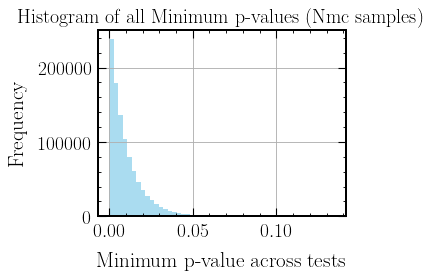

In [46]:
# MINIMUM

Nmc = pv_bin_H0.shape[0]
pv_all_H0 = np.concatenate([pv_bin_H0.reshape(Nmc, -1), pv_sum_H0.reshape(Nmc, -1)], axis=1)  # Shape: [Nmc, num_bins + 1]
print(pv_all_H0.shape)

min_pv_all_H0_BCE = np.min(pv_all_H0, axis=1)  # Shape: [Nmc]

plt.figure(figsize=(4, 3))
plt.hist(min_pv_all_H0_BCE, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Minimum p-value across tests')
plt.ylabel('Frequency')
plt.title('Histogram of all Minimum p-values (Nmc samples)')
plt.grid(True)
plt.show()


In [47]:
ts_bin_H0_BCE.shape, ts_sum_H0_BCE.shape

((999424, 102), (999424,))

---

### Summary plot

In [48]:
def analyse_BCE(obs):
    
    ts_bin_obs = ts_sbi(obs, model=1)
    ts_sum_obs = ts_bin_obs.sum()-ts_sum_H0_BCE_mean
    p_obs = t_to_pvalue_empirical(ts_sum_obs, ts_sum_H0_BCE)
    _p_nn = []
    for idx, ts_bin in enumerate(ts_bin_obs):
        ts_bin_i = ts_bin_H0_BCE[:, idx]
        m = ts_bin_i.mean()
        ts0_ref = ts_bin_i - m
        ts_obs = (ts_bin-m)
        _p_nn.append(t_to_pvalue_empirical(ts_obs, ts0_ref))  
    p_nn = np.array(_p_nn)
    p_sum_nn = t_to_pvalue_empirical(ts_sum_obs, ts_sum_H0_BCE)   

    # Compute global p-values
    obs_min_pv_bin = p_nn.reshape(-1).min()
    obs_min_pv_sum = p_sum_nn
    pv_all_obs = np.concatenate([
        p_nn.reshape(-1),  # Shape: [Nbins]
        torch.tensor([p_sum_nn])  # Shape: [1]
    ], axis=0)  # Combined shape: [num_total_tests]
    obs_min_pv_all = pv_all_obs.min()

    p_glob_bin_BCE = np.mean(min_pv_bin_H0_BCE <= obs_min_pv_bin)
    p_glob_all_BCE = np.mean(min_pv_all_H0_BCE <= obs_min_pv_all)

    return ts_bin_obs, p_nn, p_sum_nn, p_glob_all_BCE


def plot_BCE(obs, ts_bin_obs, p_nn, p_sum_nn, p_glob_all_BCE, real=False):
    
    # Figure
    mygold = (218/255, 165/255, 32/255, 0.1)  
    fig = plt.figure(figsize=(10, 8), dpi=250)
    gs = plt.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1], width_ratios=[2, 1], hspace=0.3, wspace=0.3)

    # First row: ax1 spans both columns
    ax1 = fig.add_subplot(gs[0, 0])
    xi = obs['xi'][0]
    grid = times
    if real:
        ax1.plot(grid, obs['xi'][0], color='k', label="$x_{\mathrm{obs}}$")
        ax1.set_title("GW150814")
    else:
        ni = obs['ni'][0] 
        dist = obs['xi'][0] - obs['x0'][0]
        epsilon = obs['epsilon'][0] 
        ax1.plot(grid, obs['mu'][0], color='k', label="$\mu_{\mathrm{sim}}$")
        ax1.plot(grid, obs['mu'][0]+dist, color='C1', label="$\mu_{\mathrm{dist B}}$")
        ax1.fill_between(grid, obs['mu'][0], obs['mu'][0]+dist, color='C1', alpha=0.5)
        ax1.scatter(grid, xi, color='k', marker='x', s=6)
        ax1.set_title("Data")
        ax1.legend(fontsize=12, bbox_to_anchor=[0.6,0.65,0,0], labelspacing=0.1)
    ax1.set_ylabel("$x_\mathrm{obs}$", labelpad=1.5)
    ax1.set_xticks([])

    # Second column: ax2 and ax3 in the first column
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.semilogy(grid, p_nn, c='C1', label=r"$\textsc{SBI}$")
    ax2.set_ylabel("$\mathrm{p}_\mathrm{obs}$", labelpad=1.5)
    ax2.legend(loc='best',  fontsize=13)
    ax2.set_ylim(1/(N_mc*5), 1)
    ax2.set_xticks([])
    ax2.set_title("Anomaly detection")
    ax2.grid(True, axis='y')
    ax2.set_xticks([])

    ax3 = fig.add_subplot(gs[2, 0])
    # ax3.set_facecolor(dandelion)
    ax3.plot(grid, ts_bin_obs-ts_bin_obs.min(), c='C1', label=r"$\textsc{SBI}$")
    ax3.set_ylabel(r"$t_\mathrm{obs}$")
    ax3.legend(loc='best',  fontsize=13)
    ax3.axhline(0, color='#b0b0b0', ls='--', lw=1)
    ax3.set_title("Residual analysis")
    ax3.set_xticks([])

    # Second column: ax4 and ax6 in the second column
    # Bars
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_yscale('log')
    ax4.set_ylim(1/(N_mc*5), 1)
    ax4.set_xticks([0, 1])
    ax4.set_xticklabels(["SBI", "Analytical"])
    ax4.set_xlim(-0.5, 2 - 0.5)
    ax4.set_ylabel("$\mathrm{p}_\mathrm{sum}$")
    ax4.fill_between([-0.2, 0.2], 1, p_sum_nn, facecolor='C1', edgecolor='C1')
    ax4.grid(True, axis='y', which='both')
    ax4.set_title("Model validation")
    ax4.tick_params(axis="x",direction="in", pad=-25)
    ax4.minorticks_off()

    # Add on gs[0, 1] text reporting the three global p-values
    mantissa, exp = ('%.2e' % p_glob_all_BCE).split('e')
    exp = int(exp)
    textstr = r'$\mathrm{p}_{\mathrm{glob}}= %s \times 10^{%d}$' % (mantissa, exp)
    ax3.text(0.6, -0.4, textstr, transform=ax3.transAxes, fontsize=14,
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(
                    facecolor=mygold,
                    edgecolor='none'  # Remove the border if not needed
                )
            )
    ax3.text(0.2, -0.4, "Global p-value", transform=ax3.transAxes, fontsize=18,
                verticalalignment='center', horizontalalignment='center')


Loading data for H1 at GPS time 1126259462.4
Loading PSD for H1 at GPS time 1126259462.4 [can take O(1 min)]
Loading posterior samples from GW150814_posterior_samples.npz


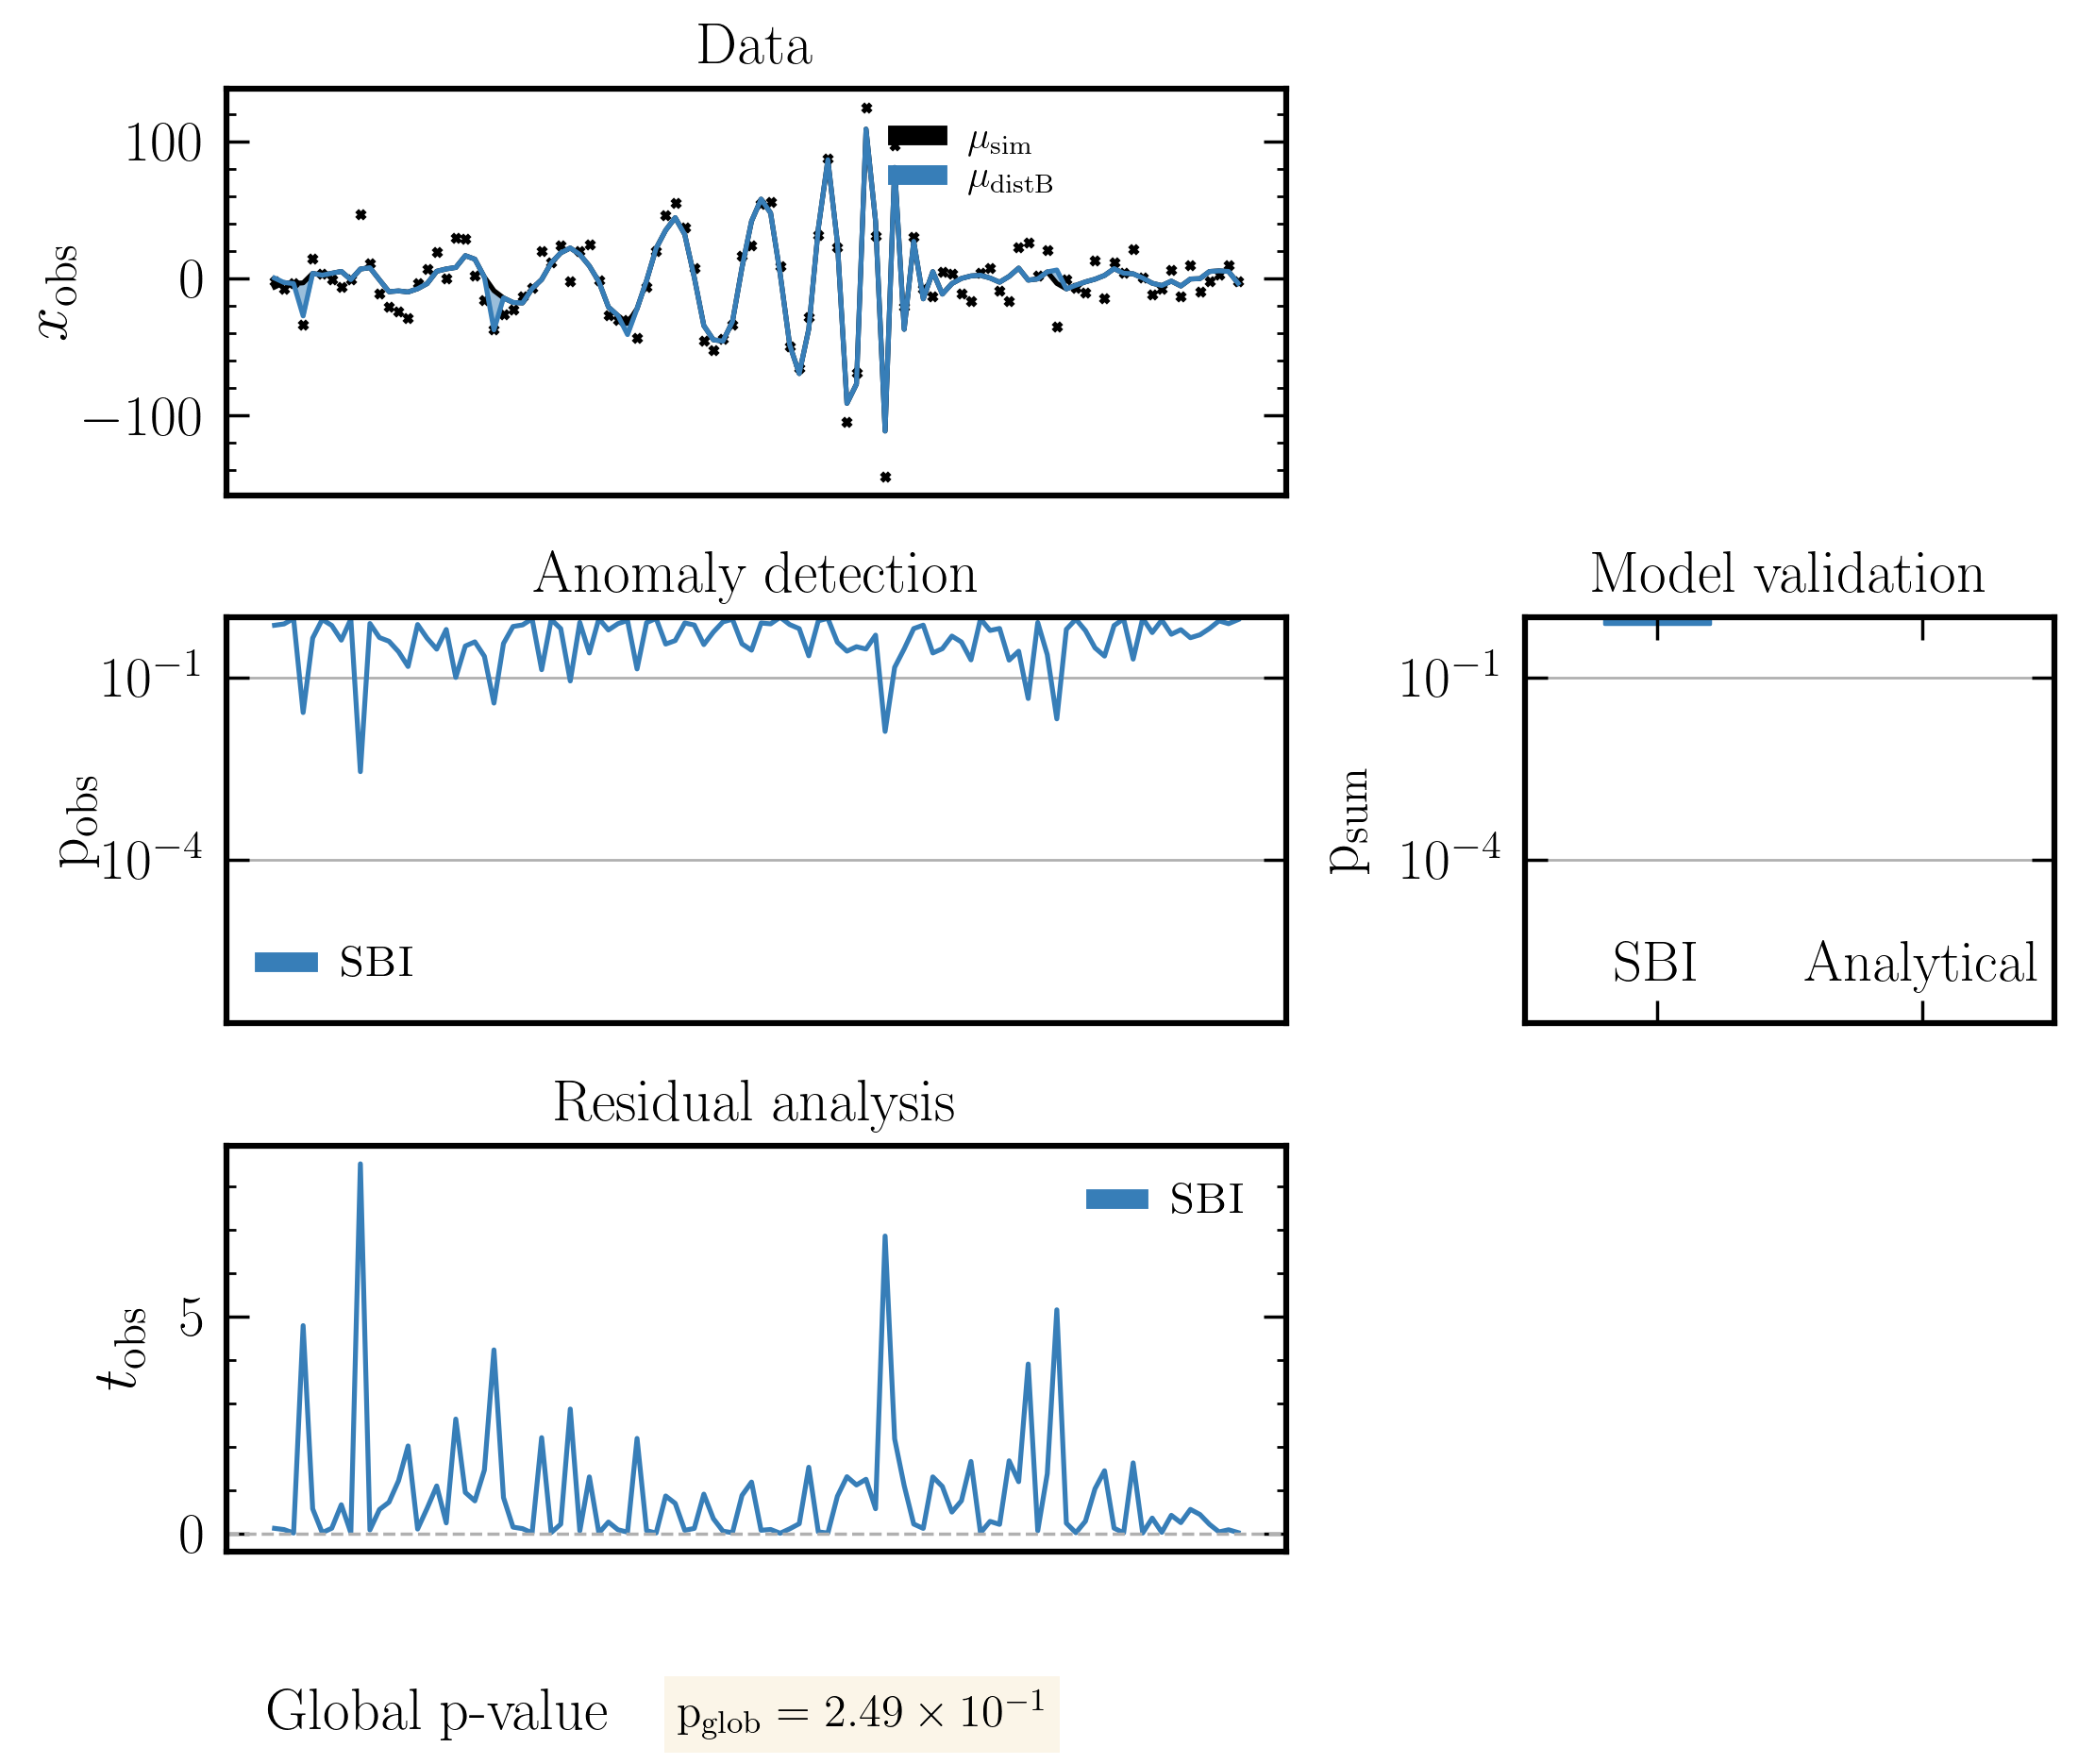

In [49]:
# OBS
simulator1 = GW150814_Additive(gw150814_samples=gw150814_samples, dtype=torch.float32, bounds=bounds, fraction=0.05) #    # Just one bin is distorted with fraction=None  
obs = simulator1.sample(1) 

# obs = torch.load("figures/test0.pt")
ts_bin_obs, p_nn_BCE, p_sum_nn_BCE, p_glob_all_BCE = analyse_BCE(obs)
plot_BCE(obs, ts_bin_obs, p_nn_BCE, p_sum_nn_BCE, p_glob_all_BCE)


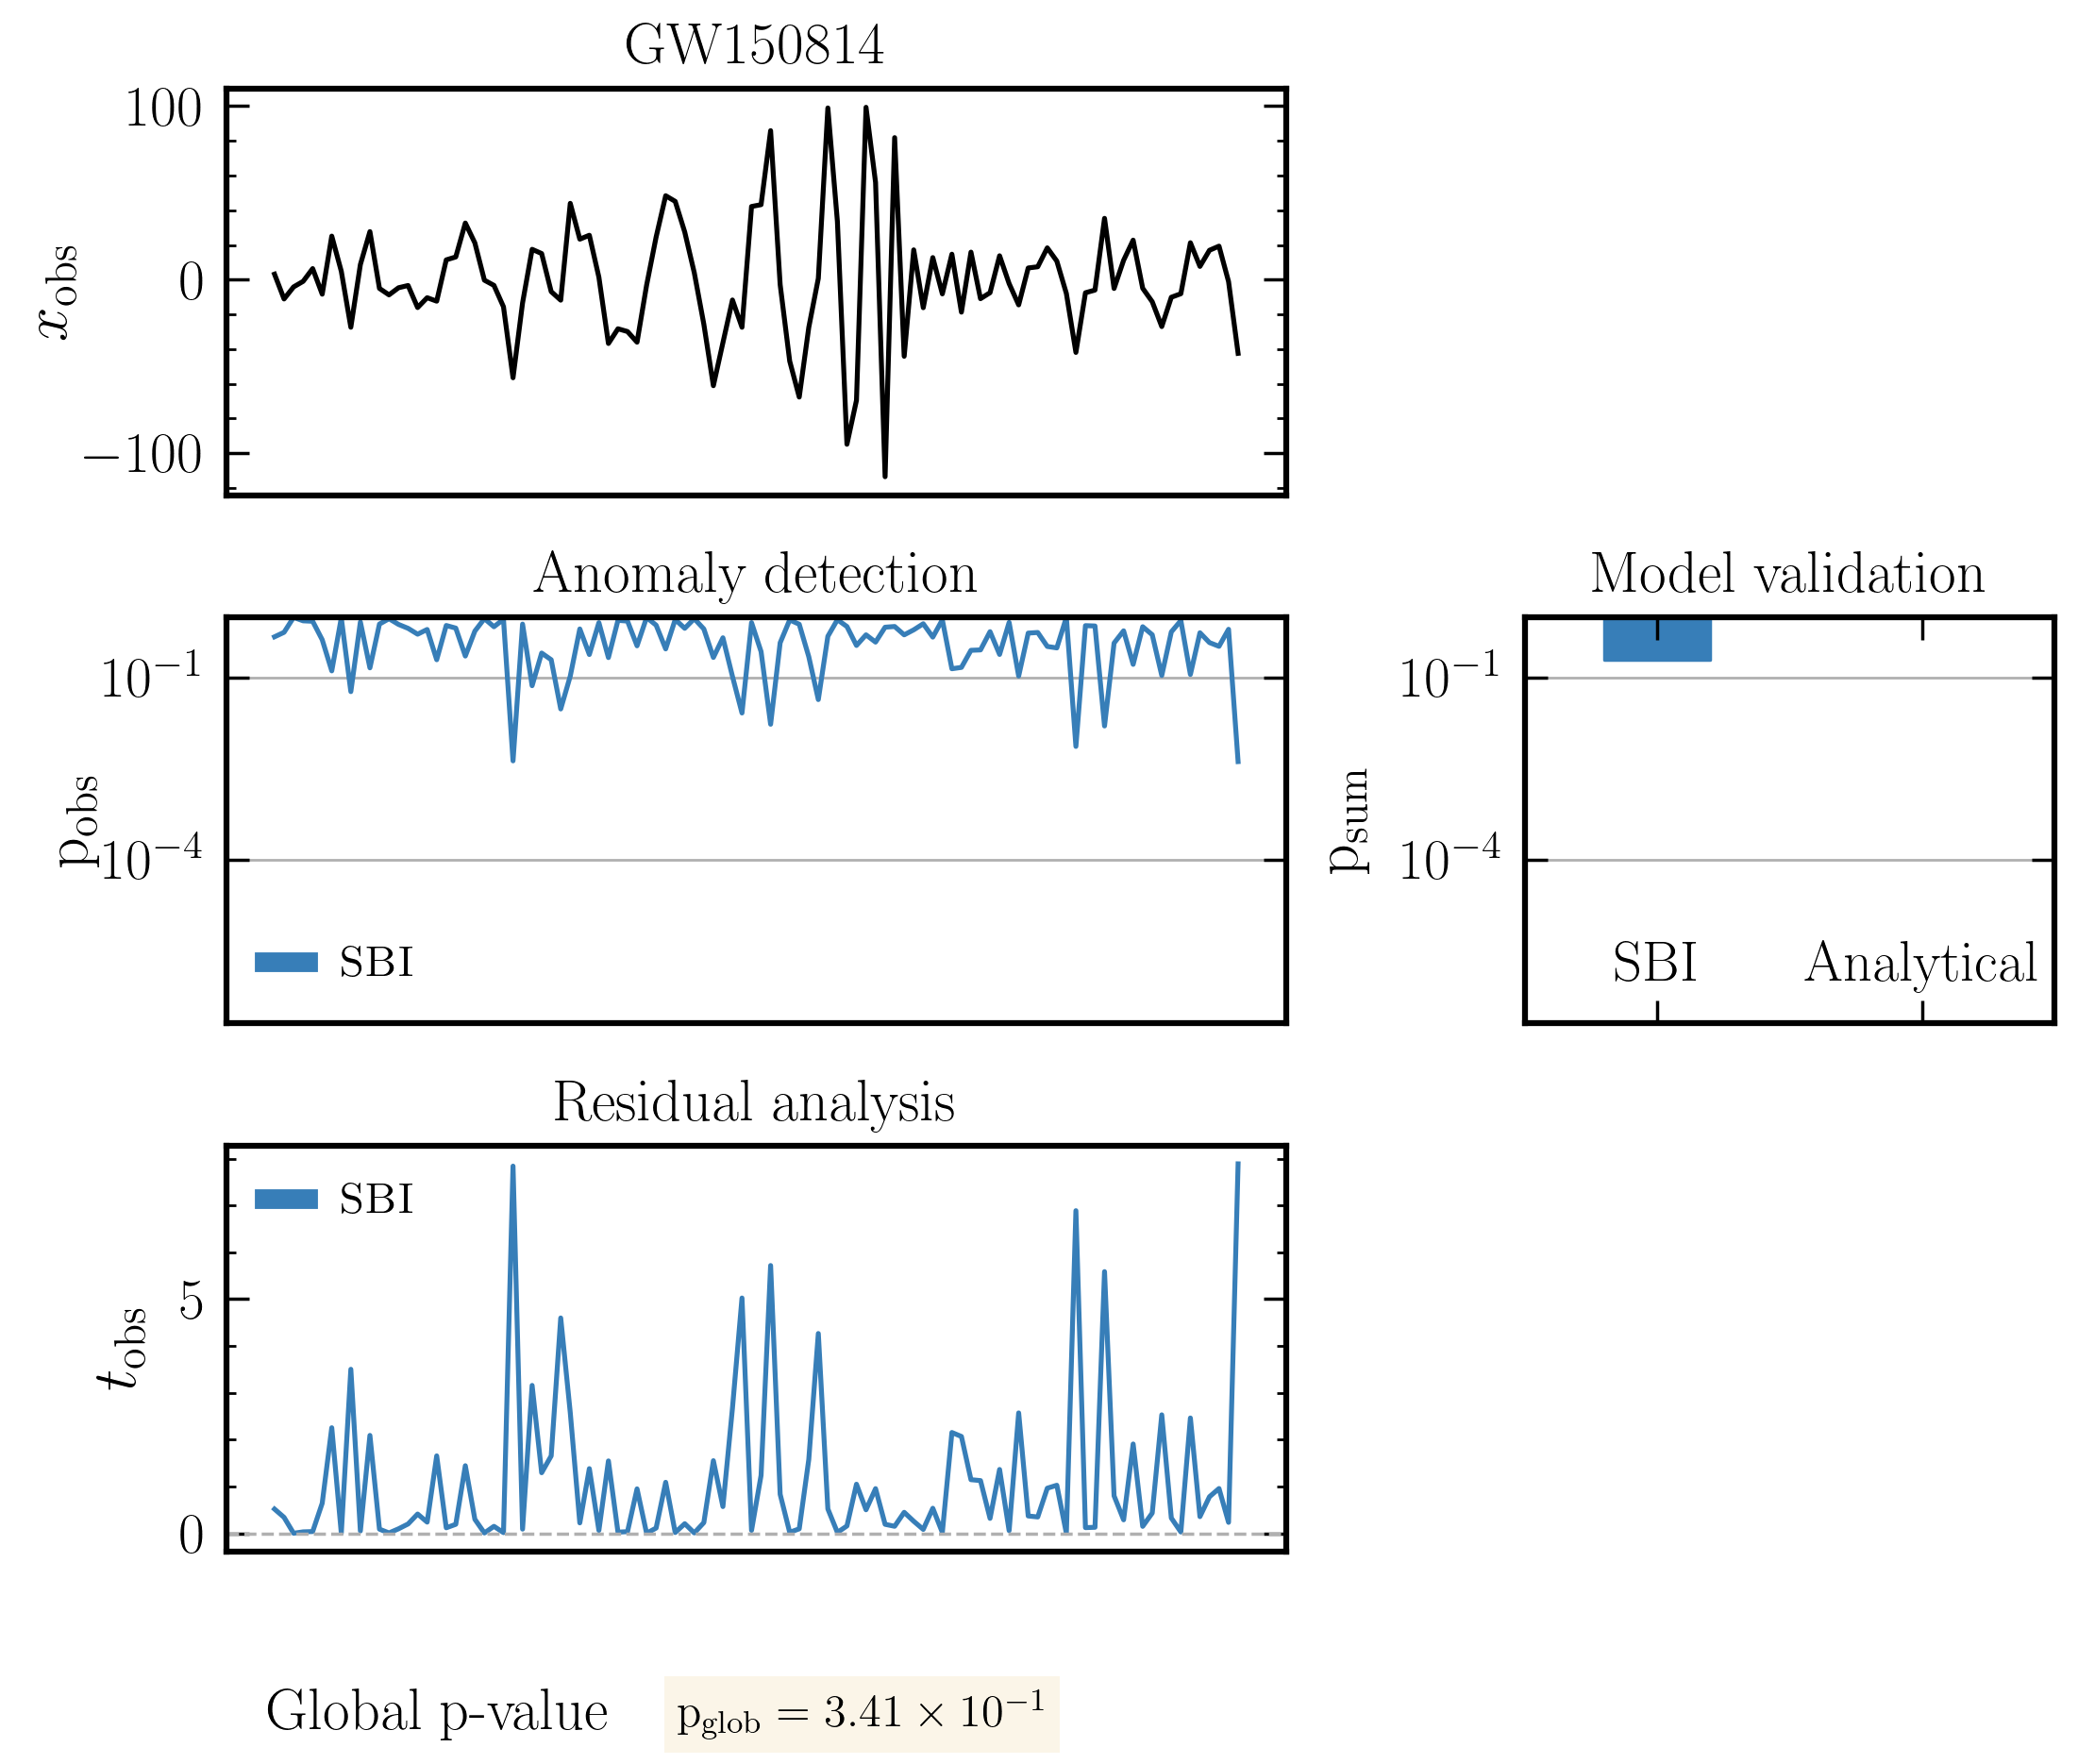

In [50]:
# REAL DATA
gw150814 = simulator._jax_to_torch(simulator._process(simulator.filter_gwosc_data()))
obs = {'xi': gw150814.unsqueeze(0).to(torch.float32)}

ts_bin_obs, p_nn_BCE, p_sum_nn_BCE, p_glob_all_BCE = analyse_BCE(obs)
plot_BCE(obs, ts_bin_obs, p_nn_BCE, p_sum_nn_BCE, p_glob_all_BCE, real=True)

## Combine plot

In [51]:
def plot_together(
    obs, 
    ts_bin_obs, p_nn_BCE, p_sum_nn_BCE, p_glob_all_BCE,
    epsilon_nn, variance_nn, snr2_nn, p_nn_SNR, p_sum_nn_SNR, p_glob_all_SNR,
    real=False
    ):
    
    mygold = (218/255, 165/255, 32/255, 0.1)  
    mycolors = ['#570f6d', '#bb3754', '#f98e08']
    fig = plt.figure(figsize=(10, 8), dpi=200)
    gs = plt.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1], width_ratios=[2, 1])

    ### FIRST PART
    # First row: ax1 spans both columns
    ax1 = fig.add_subplot(gs[0, 0])
    xi = obs['xi'][0]
    grid = times
    if real:
        ax1.plot(grid, obs['xi'][0], color='k', label="$x_{\mathrm{obs}}$")
        ax1.set_title("GW150814")
    else:
        ni = obs['ni'][0] 
        dist = obs['xi'][0] - obs['x0'][0]
        epsilon = obs['epsilon'][0] 
        ax1.plot(grid, obs['mu'][0], color='k', label="$\mu_{\mathrm{sim}}$")
        ax1.plot(grid, obs['mu'][0]+dist, color='C1', label="$\mu_{\mathrm{dist B}}$")
        ax1.fill_between(grid, obs['mu'][0], obs['mu'][0]+dist, color='C1', alpha=0.5)
        ax1.scatter(grid, xi, color='k', marker='x', s=6)
        ax1.set_title("Data")
        ax1.legend(fontsize=12, bbox_to_anchor=[0.6,0.65,0,0], labelspacing=0.1)
    ax1.set_ylabel("$x_\mathrm{obs}$", labelpad=1.5)
    ax1.set_xticks([])

    # Second column: ax2 and ax3 in the first column
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.semilogy(grid, p_nn_BCE, c=mycolors[1], label=r"$\textsc{BCE}$")
    ax2.semilogy(grid, p_nn_SNR, c=mycolors[2], label=r"$\textsc{SNR}$")
    ax2.set_ylabel("$\mathrm{p}_\mathrm{obs}$", labelpad=1.5)
    ax2.set_ylim(1/(N_mc*5), 1)
    ax2.set_xticks([])
    ax2.set_title("Anomaly detection")
    ax2.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
    ax2.yaxis.set_minor_locator(ticker.NullLocator())
    ax2.grid(True, axis='y', which='major')
    ax2.set_yticks([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])  # Specify tick positions
    ax2.set_yticklabels([r"$10^{-1}$", None , r"$10^{-3}$", None, r"$10^{-5}$", None])  # Customize tick labels
    # ax2.legend(loc='best', fontsize=13, frameon=True, facecolor='white', framealpha=1, fancybox=True, edgecolor='white')

    ax3 = fig.add_subplot(gs[2, 0])
    ax3.plot(grid, ts_bin_obs-ts_bin_obs.min(), c=mycolors[1], label=r"$\textsc{BCE}$")
    ax3.plot(grid, snr2_nn-snr2_nn.min(), c=mycolors[2], label=r"$\textsc{SNR}$")
    # ax3.plot(grid, snr2_analytical - snr2_analytical.min(), c='blue', ls='dotted',label=r"analytical")
    ax3.set_ylabel(r"$t_\mathrm{obs}$")
    ax3.legend(loc='upper right', fontsize=13)
    ax3.set_ylim(-.1, None)
    ax3.set_xticks([])
    ax3.set_title("Localized $t_i$")
    # ax3.grid(True, axis='y', which='both')


    # Second column: ax4 and ax6 in the second column

    # Bars
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_yscale('log')
    ax4.set_ylim(1/(N_mc*5), 1)
    ax4.set_xticks([0, 1])
    ax4.set_xticklabels(["BCE", "SNR"])
    ax4.set_xlim(-0.5, 2 - 0.5)
    ax4.set_ylabel("$\mathrm{p}_\mathrm{sum}$")
    ax4.fill_between([-0.2, 0.2], 1, p_sum_nn_BCE, facecolor=mycolors[1], edgecolor=mycolors[1])
    ax4.fill_between([0.8, 1.2], 1, p_sum_nn_SNR, facecolor=mycolors[2], edgecolor=mycolors[2])
    ax4.set_title("Model validation")
    ax4.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
    ax4.yaxis.set_minor_locator(ticker.NullLocator())
    ax4.grid(True, axis='y', which='major')
    ax4.set_yticks([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])  # Specify tick positions
    ax4.set_yticklabels([r"$10^{-1}$", None , r"$10^{-3}$", None, r"$10^{-5}$", None])  # Customize tick labels
        
    # Add on gs[0, 1] text reporting the three global p-values
    ax_text = fig.add_subplot(gs[0, 1])
    mantissa, exp = ('%.2e' % p_glob_all_BCE).split('e')
    exp = int(exp)
    textstr = r'$\mathrm{p}_{\mathrm{glob, BCE}}= %s \times 10^{%d}$' % (mantissa, exp)
    ax_text.text(0.5, 0.7, textstr, transform=ax_text.transAxes, fontsize=15,
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(
                    facecolor=mygold,
                    edgecolor='none'  # Remove the border if not needed
                )
            )
    mantissa, exp = ('%.2e' % p_glob_all_SNR).split('e')
    exp = int(exp)
    textstr = r'$\mathrm{p}_{\mathrm{glob, SNR}}= %s \times 10^{%d}$' % (mantissa, exp)
    ax_text.text(0.5, 0.4, textstr, transform=ax_text.transAxes, fontsize=15,
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(
                    facecolor=mygold,
                    edgecolor='none'  # Remove the border if not needed
                )
            )
    ax_text.axis('off')
    ax_text.set_title("Global p-value")

    plt.tight_layout()

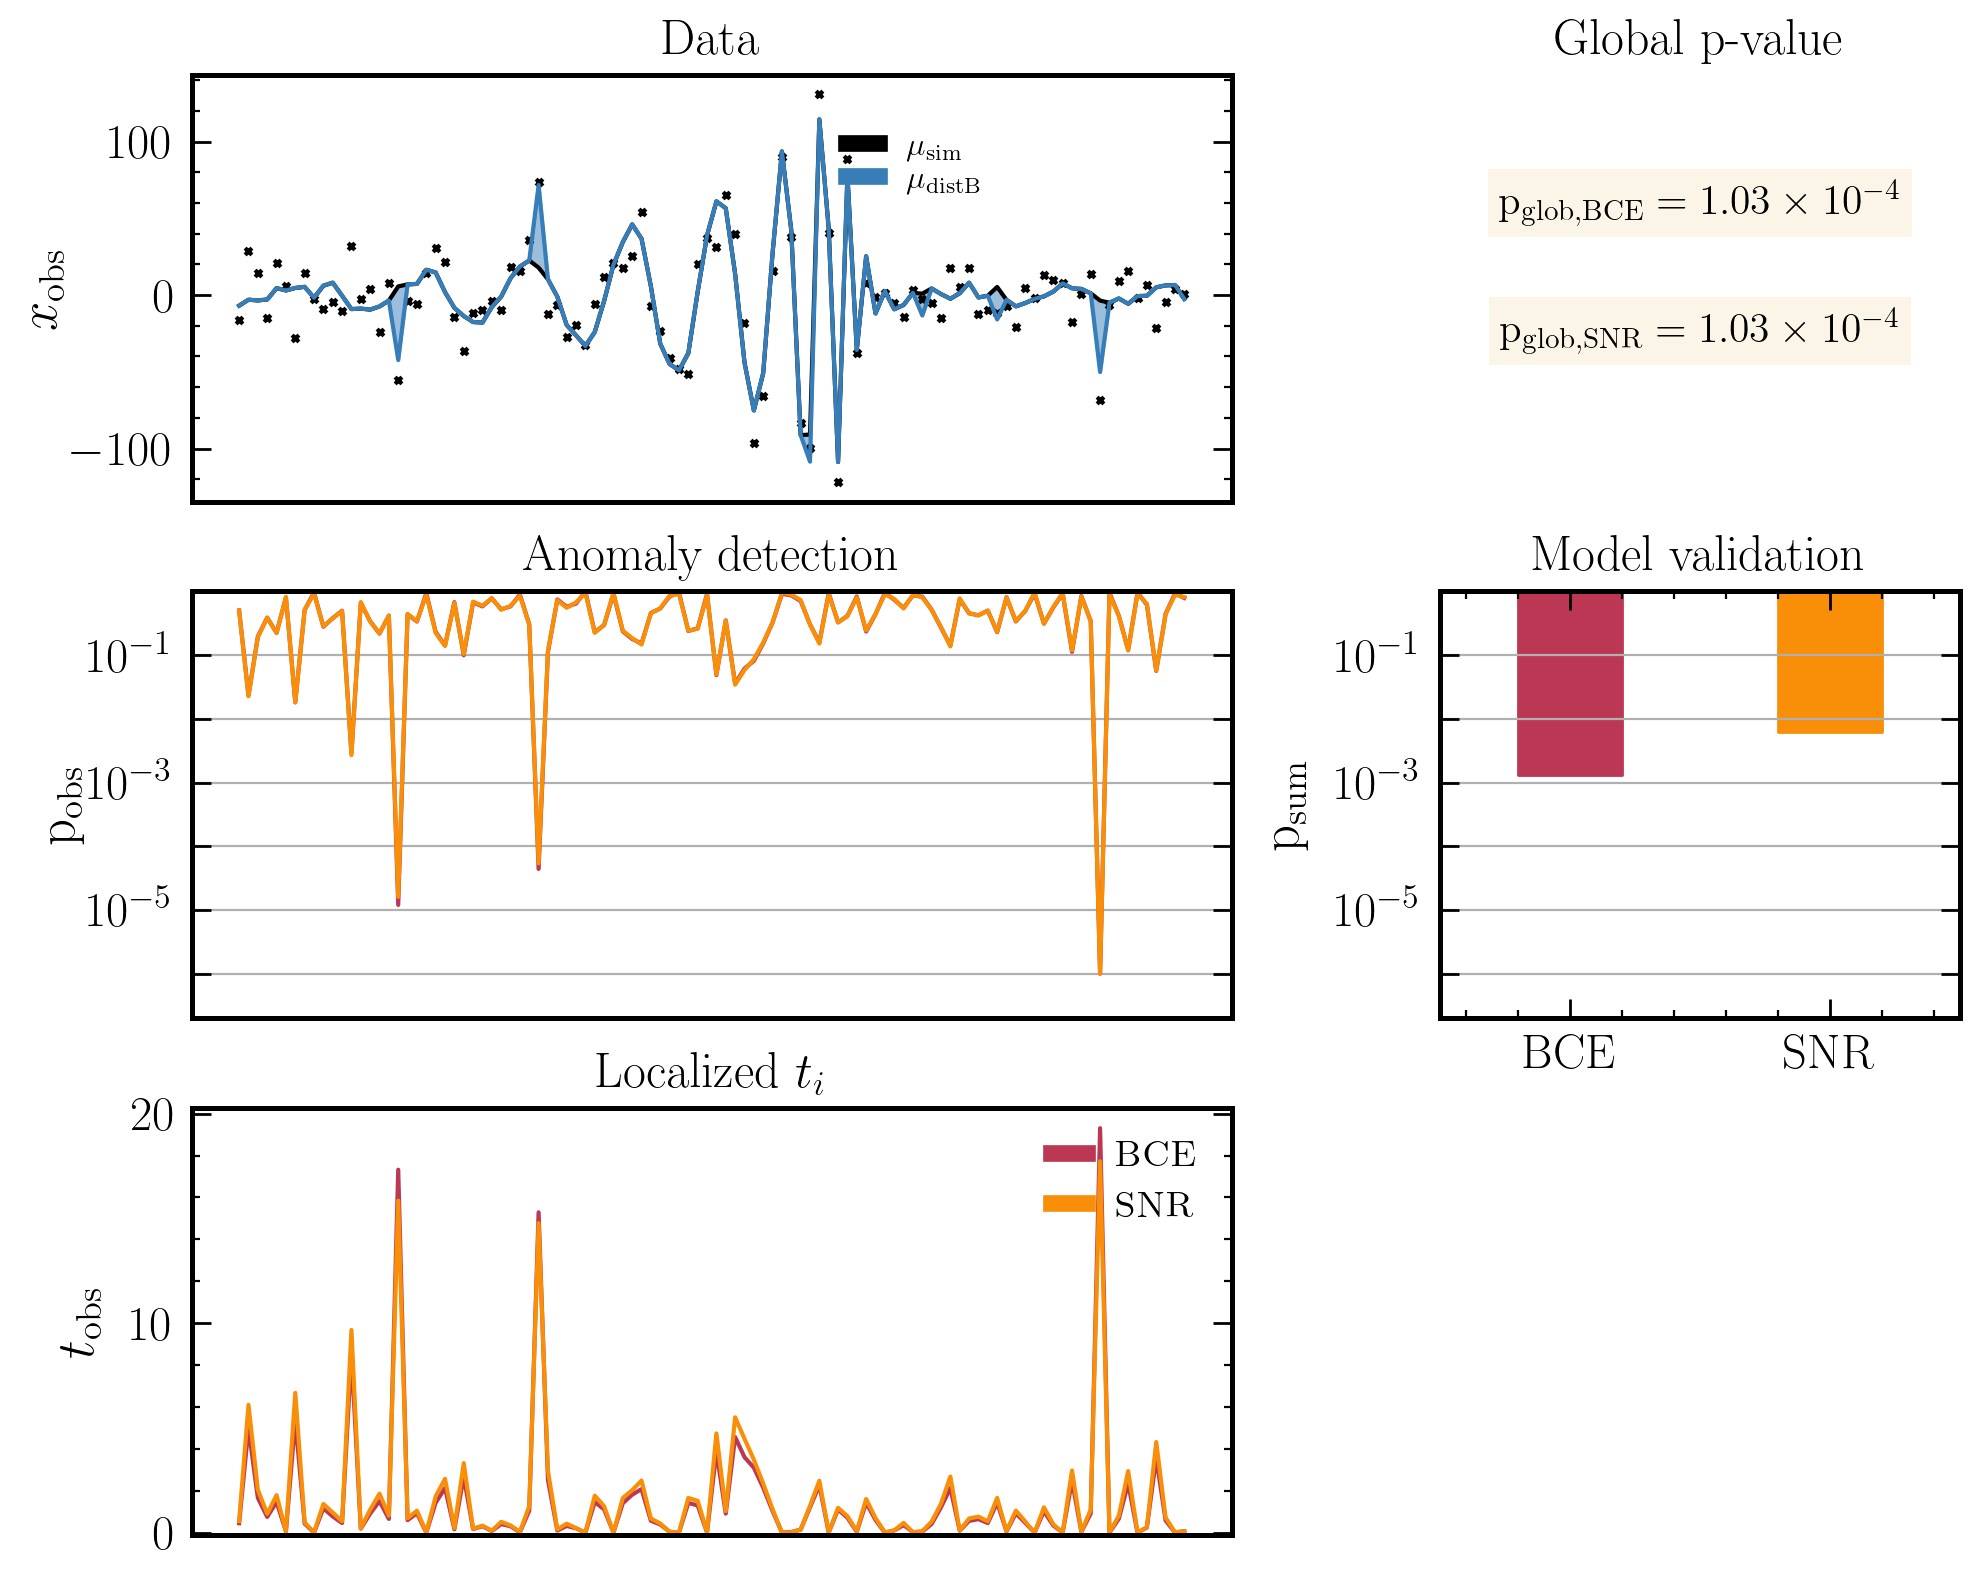

In [52]:
# simulator1 = GW150814_Additive(gw150814_samples=gw150814_samples, dtype=torch.float32, bounds=bounds, fraction=0.05) #    # Just one bin is distorted with fraction=None  
obs = simulator1.sample(1) 
    
ts_bin_obs, p_nn_BCE, p_sum_nn_BCE, p_glob_all_BCE = analyse_BCE(obs)
epsilon_nn, variance_nn, snr2_nn, p_nn_SNR, p_sum_nn_SNR, p_glob_all_SNR = analyse_SNR(obs)

plot_together(
    obs, 
    ts_bin_obs, p_nn_BCE, p_sum_nn_BCE, p_glob_all_BCE,
    epsilon_nn, variance_nn, snr2_nn, p_nn_SNR, p_sum_nn_SNR, p_glob_all_SNR
    )

# plt.savefig("./figs/gw150814.pdf", dpi=300, transparent=True)

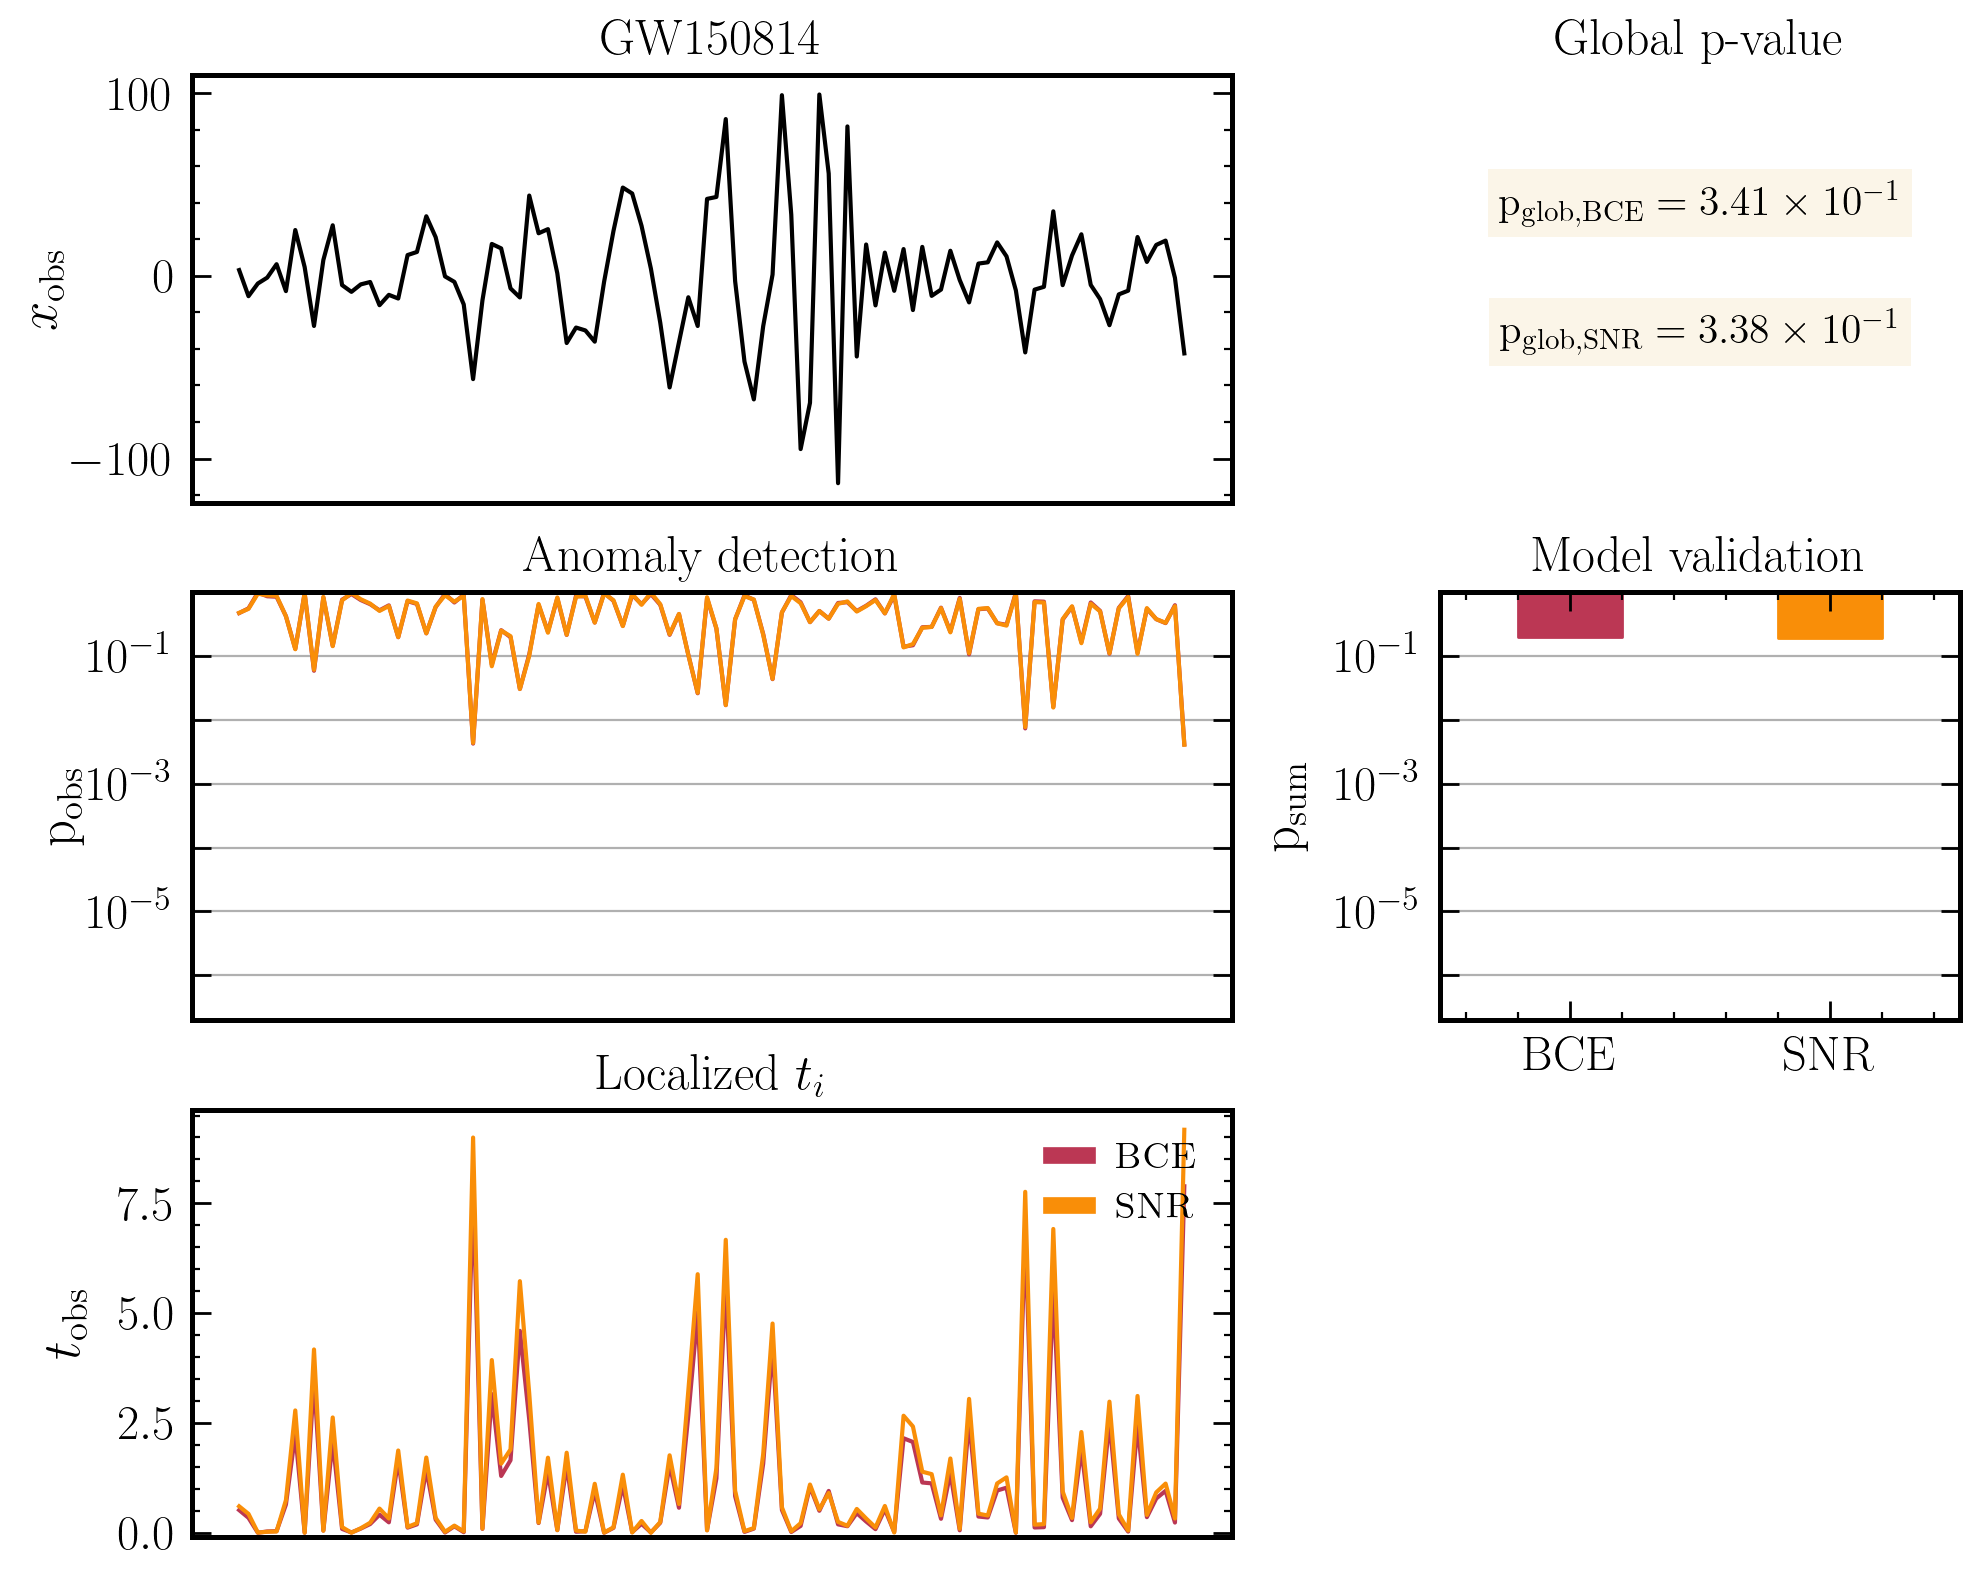

In [53]:
gw150814 = simulator._jax_to_torch(simulator._process(simulator.filter_gwosc_data()))
obs = {'xi': gw150814.unsqueeze(0).to(torch.float32)}

ts_bin_obs, p_nn_BCE, p_sum_nn_BCE, p_glob_all_BCE = analyse_BCE(obs)
epsilon_nn, variance_nn, snr2_nn, p_nn_SNR, p_sum_nn_SNR, p_glob_all_SNR = analyse_SNR(obs)

plot_together(
    obs, 
    ts_bin_obs, p_nn_BCE, p_sum_nn_BCE, p_glob_all_BCE,
    epsilon_nn, variance_nn, snr2_nn, p_nn_SNR, p_sum_nn_SNR, p_glob_all_SNR,
    real=True
    )

# plt.savefig("./figs/gw150814.pdf", dpi=300, transparent=True)